In [1]:
import os
PATH_DATA = os.environ["DATA_HOME"]+"/structurated/csv/"



# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Información sobre los datos

* Encounter ID 
    - ID único de la admisión de un paciente
* Patient number 
    - ID único de paciente
* Race 
    - Raza
* Gender
    - Sexo
* Age
    - Edad (en intervalos de 10 años)
    
* Weight
    - Peso en libras
* Admission type 
    - Identificador del tipo de admisión 
* Discharge disposition
    - Identificador del tipo de alta 
* Admission source
    - Identificador de la fuente de admisión 
* Time in hospital 
    - Número de días que han pasado entre admission y discharge (admisión y alta)
* Payer code
    - Identificador del código de pago
* Medical specialty
    - Identificador de la especialidad médica donde es ingresado el paciente
* Number of lab procedures 
    - Número de análisis en laboratorio que se han llevado a cabo durante el ingreso del paciente
* Number of procedures 
    - Número de procedimientos (diferentes a los análisis en laboratorio) que se han llevado a cabo durante el ingreso del paciente
* Number of medications
    - Número de nombres de medicamentos distintos que se hayan administrado al paciente durante su ingreso
* Number of outpatient visits
    - Número de visitas como paciente externo (no ingresado, por ejemplo) que ha tenido el paciente durante el año antes de esta admisión
* Number of emergency
    - Numero de visitas de emergencia del paciente durante el año antes de esta admisión
* Number of inpatient visits 
    - Número de visitas en las que ha estado ingresado el paciente durante el año antes de esta admisión
* Diagnosis 1 
    - Diagnóstico primario (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Diagnosis 2 
    - Diagnóstico secundario (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Diagnosis 3 
    - Diagnóstico adicional (codificado como los tres primeros dígitos del ICD9)
    - Descripción de los códigos ICD9: http://icd9.chrisendres.com/index.php?action=contents
* Number of diagnoses 
    - Número de diagnósticos que se han introducido al sistema
* Glucose serum test result 
    - Indica el rango del resultado de la prueba de glucosa, o si no se llevó a cabo la prueba. Valores: “>200,” “>300,” “normal,” y “none” si no se realizó la prueba
* A1c test result
    - Indica el rango del resultado de la prueba de hemoglobina A1c, o si no se llevó a cabo la prueba. Valores: “>8” si el resultado fue mayor del 8%, “>7” si el resultado fue mayor del 7% pero menor del 8%, “normal” si el resultado fue menor del 7%, y “none” si no se realizó la prueba.
* Change of medications 
    - Indica si ha habido un cambio en la medicación para la diabetes (tanto en la dosis como en el propio medicamento)
* Diabetes medications 
    - Indica si ha el paciente toma medicación para la diabetes
* 24 features for medications
    - Para los nombres genéricos de los medicamentos metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiridepioglitazone, metformin-rosiglitazone, y metforminpioglitazone, la variable indica si se prescribió o no el medicamento durante la visita del paciente
    - Valores: “up” si se subió la dosis durante la visita, “down” si se bajó la dosis, “steady” si la dosis no cambió, y “no” si no se prescribió el medicamento
* Readmitted 
    - Indica cuántos días ha tardado el paciente en volver al hospital y ser readmitido. Valores: “<30” si el paciente fue readmitido en menos de 30 días, “>30” si el paciente fue readmitido en más de 30 días, y “No” si el paciente no ha sido readmitido



## Cargar librerías

In [2]:
%matplotlib inline

import re
import random
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.cluster import KMeans



## Lectura de datos

In [3]:
diabetes = pd.read_csv(PATH_DATA+'DiabetesData/diabetic_data.csv')
admission_source = pd.read_csv(PATH_DATA+'DiabetesData/admission_source_id.csv')
admission_type = pd.read_csv(PATH_DATA+'DiabetesData/admission_type_id.csv')
discharge_disposition = pd.read_csv(PATH_DATA+'DiabetesData/discharge_disposition_id.csv')



### comprobar correcta lectura de los datos

In [4]:
diabetes.shape

(101766, 50)

In [5]:
display(diabetes.head())
display(admission_source.head())
display(admission_type.head())
display(discharge_disposition.head())

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution




### juntar todos los datos en el mismo DataFrame

In [6]:
main_df = diabetes.merge(
    admission_source.rename(columns={"description":"description_admision_source"}), on="admission_source_id", how="left",
).merge(
    admission_type.rename(columns={"description":"description_admision_type"}), on="admission_type_id", how="left", 
).merge(
    discharge_disposition.rename(columns={"description":"description_disposition"}), on="discharge_disposition_id", how="left",
)

display(main_df.head())

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_admision_source,description_admision_type,description_disposition
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,NO,Physician Referral,None,Not Mapped
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,No,No,No,Ch,Yes,>30,Emergency Room,Emergency,Discharged to home
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,No,No,No,Ch,Yes,NO,Emergency Room,Emergency,Discharged to home




### estudiar las dimensiones del dataset

In [7]:
main_df.shape

(101766, 53)

In [8]:
main_df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [9]:
main_df.describe(include='object')

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,description_admision_source,description_admision_type,description_disposition
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,4,...,2,2,2,2,2,2,3,17,8,26
top,Caucasian,Female,[70-80),?,?,?,428,276,250,None,...,No,No,No,No,No,Yes,NO,Emergency Room,Emergency,Discharged to home
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,96420,...,101753,101765,101764,101765,54755,78363,54864,57494,53990,60234




## Data Wrangling



### cambiar los nombres de las columnas para que cumplan buenas prácticas

In [62]:
main_df.rename(columns={
    'A1Cresult': 'a1cresult',
    'glyburide-metformin':'glyburide_metformin',
    'glipizide-metformin':'glipizide_metformin',
    'glimepiride-pioglitazone':'glimepiride_pioglitazone',
    'metformin-rosiglitazone':'metformin_rosiglitazone',
    'metformin-pioglitazone':'metformin_pioglitazone',
    'diabetesMed':'diabetesmed'
}, inplace=True)
main_df.columns

seed = 42
X = main_df.drop(columns=["readmitted"])
y = main_df["readmitted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)



### estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

In [63]:
X_train[X_train.columns[40:50]].head()

,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,description_admision_source
83900,No,No,No,No,No,No,No,No,No,Emergency Room
88539,No,No,No,No,No,No,No,No,No,Emergency Room
19948,No,No,No,No,No,No,No,No,No,Emergency Room
47364,No,No,No,No,No,No,No,No,No,Physician Referral
42833,No,Up,No,No,No,No,No,Ch,Yes,Emergency Room


In [12]:
y_train.value_counts()

NO     41189
>30    26627
<30     8508
Name: readmitted, dtype: int64

In [13]:
observed_cols = ["age", "weight", "diag_1", "diag_2", "diag_3"]
X_train[observed_cols].dtypes

age       object
weight    object
diag_1    object
diag_2    object
diag_3    object
dtype: object

In [14]:
for col in observed_cols:
    print("\n"+"-"*10+col+"-"*10)
    display(X_train.groupby([col]).size())


----------age----------


age
[0-10)        120
[10-20)       515
[20-30)      1229
[30-40)      2835
[40-50)      7341
[50-60)     12901
[60-70)     16862
[70-80)     19535
[80-90)     12878
[90-100)     2108
dtype: int64


----------weight----------


weight
>200             2
?            73929
[0-25)          32
[100-125)      461
[125-150)      101
[150-175)       30
[175-200)        6
[25-50)         77
[50-75)        677
[75-100)      1009
dtype: int64


----------diag_1----------


diag_1
11      6
110     1
112    58
115     2
117     7
       ..
V63     6
V66     2
V67     1
V70     1
V71     3
Length: 688, dtype: int64


----------diag_2----------


diag_2
11       2
110      6
111      1
112    149
114      1
      ... 
V66      5
V70      7
V72      9
V85    124
V86      2
Length: 704, dtype: int64


----------diag_3----------


diag_3
11       1
110     14
111      1
112    163
115      1
      ... 
V66     13
V70      2
V72      4
V85     68
V86      1
Length: 758, dtype: int64

In [ ]:
X_train_mod = X_train.copy()

In [84]:
X_train_mod = X_train_mod.assign(
        age=X_train_mod.age.apply(lambda x: int(x.replace("[","").replace(")","").split("-")[0]))
    ).assign(
        weight=X_train_mod.weight.apply(lambda x: np.nan if x=='?' else int(x.replace("[","").replace(")","").replace(">","").split("-")[0]))
    )



### estudiar si hay registros repetidos

In [65]:
X_train_mod[X_train_mod.duplicated()]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,description_admision_source,description_admision_type,description_disposition




### estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

In [17]:
columns_x = y_train.unique()+'_x'
columns_y = y_train.unique()+'_y'
y_train.value_counts(normalize=True)

NO     0.539660
>30    0.348868
<30    0.111472
Name: readmitted, dtype: float64

In [18]:
id_or_desc_cols = ["payer_code", 
    "description_admision_source", "description_admision_type", "description_disposition",
    "medical_specialty", "diag_1", "diag_2", "diag_3"]

<ipython-input-19-0dfbcb17082a>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2, figsize=(14,4))


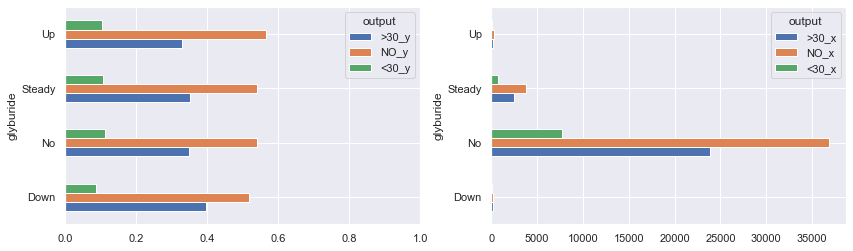

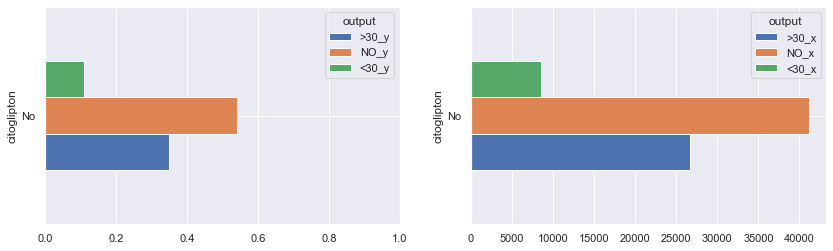

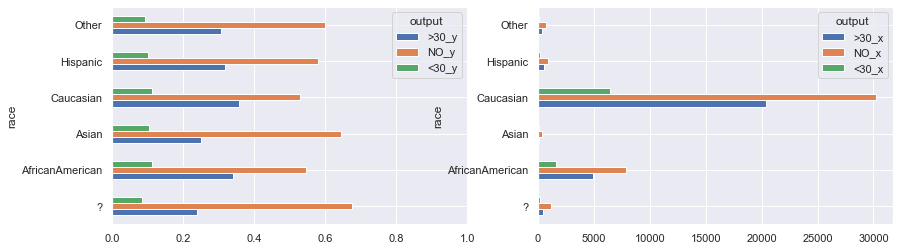

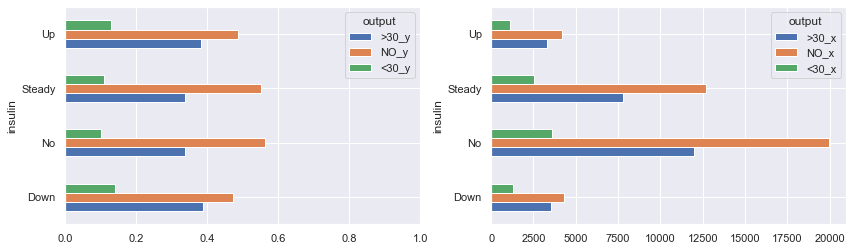

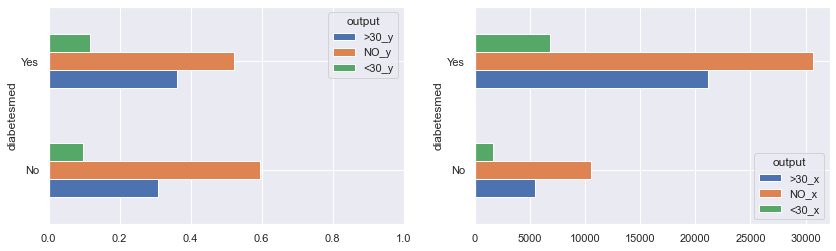

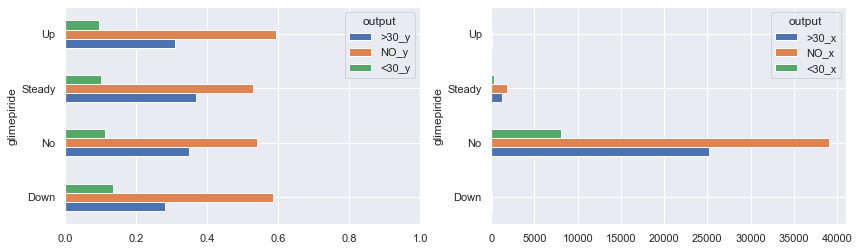

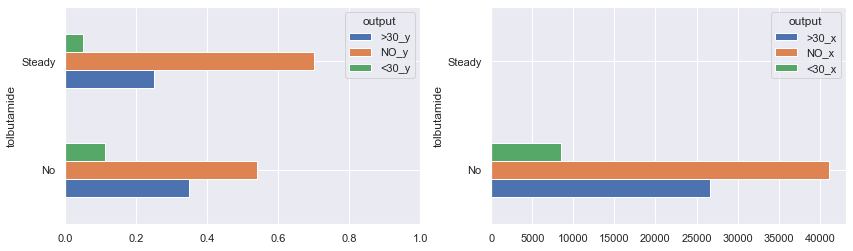

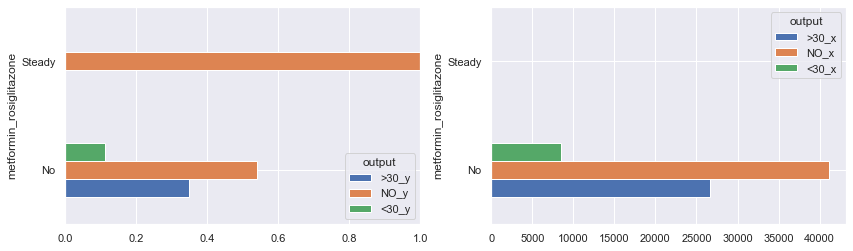

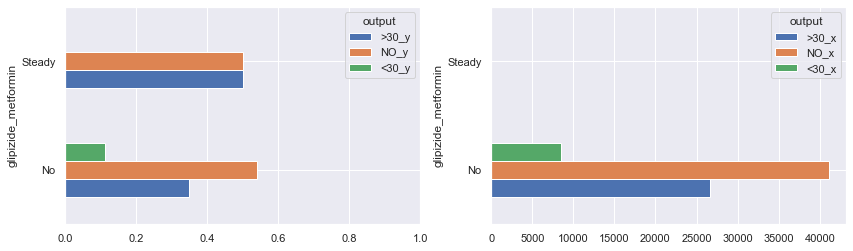

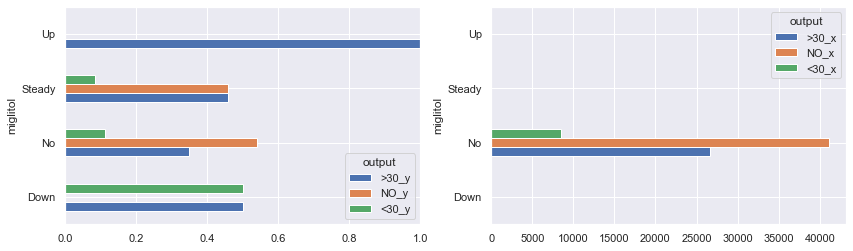

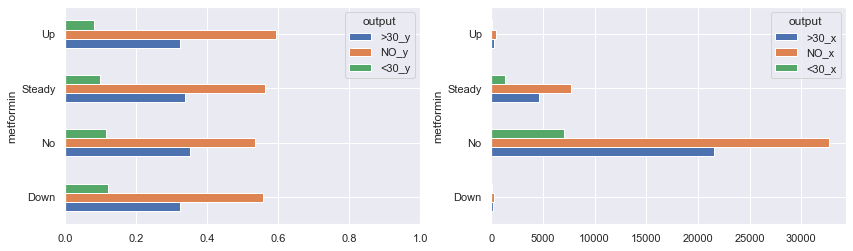

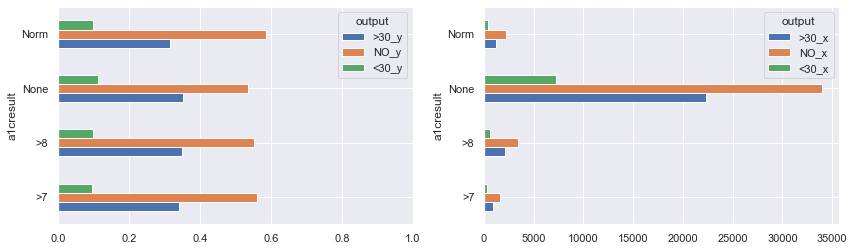

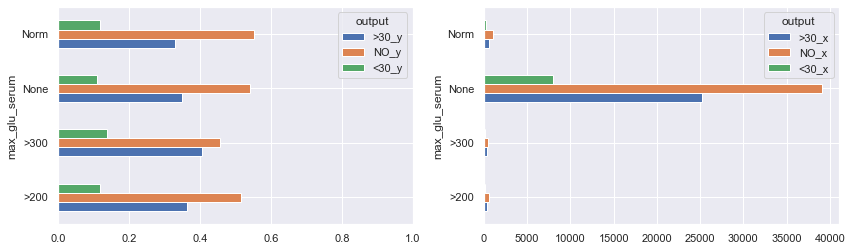

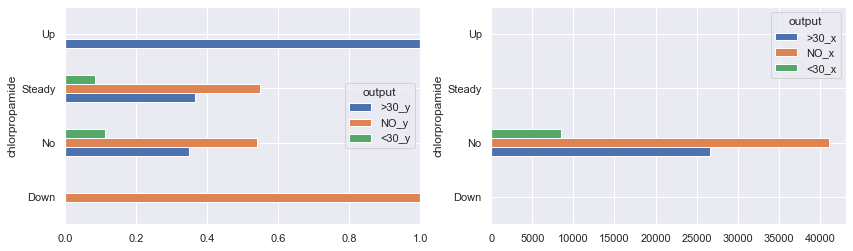

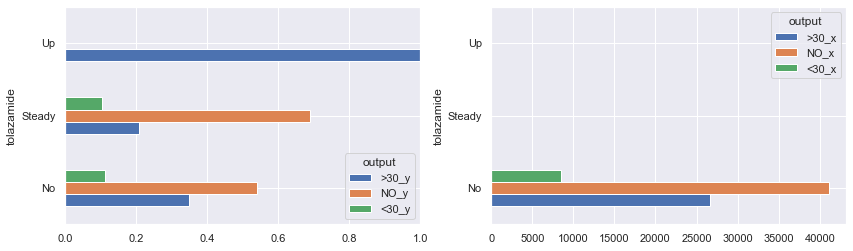

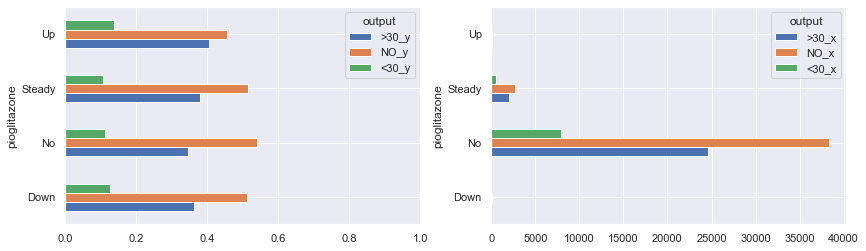

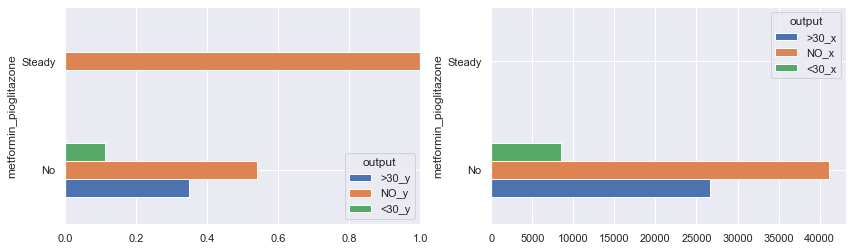

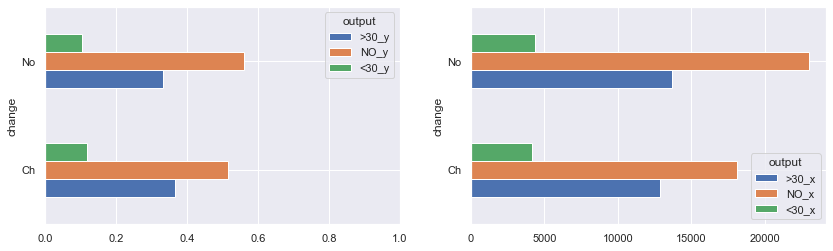

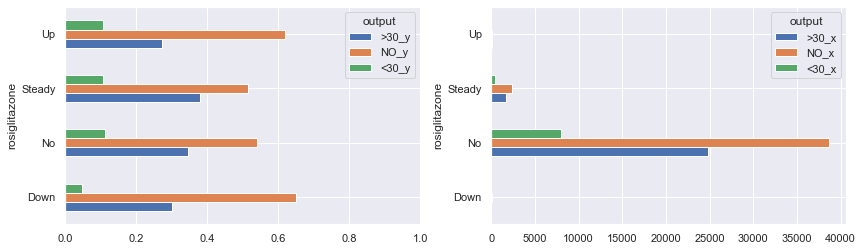

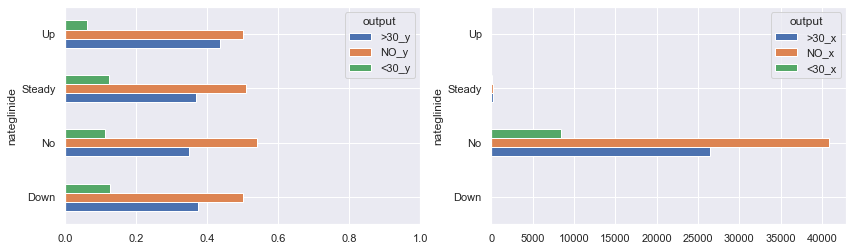

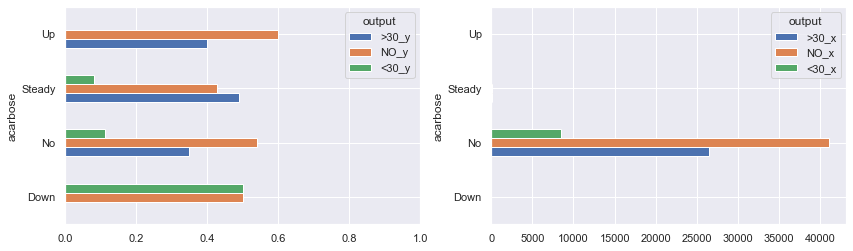

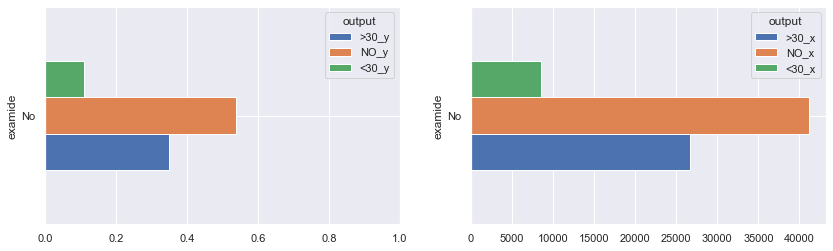

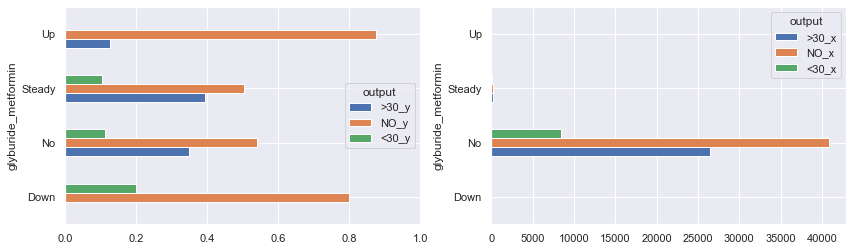

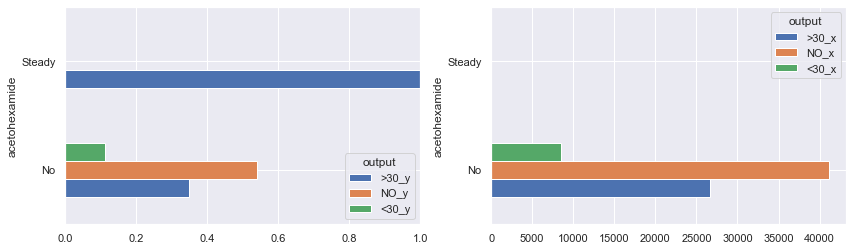

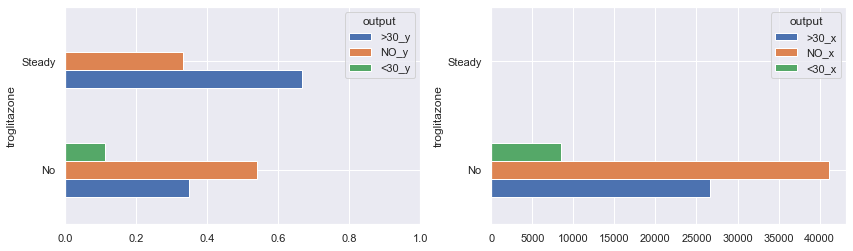

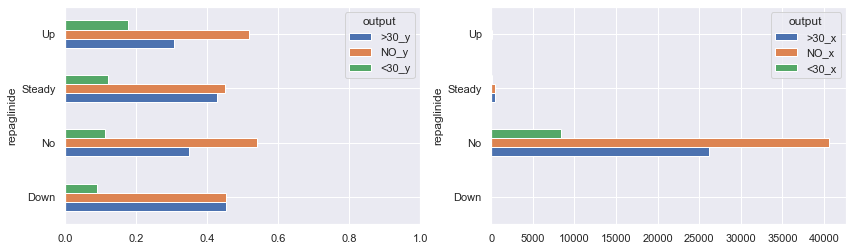

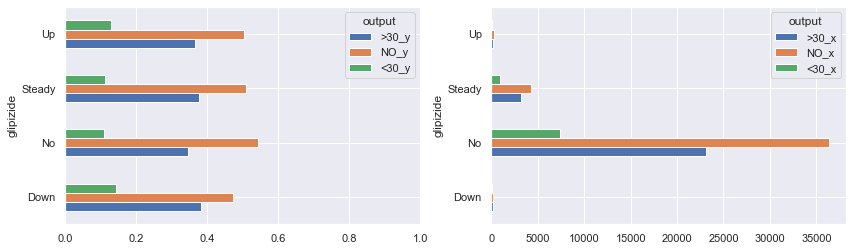

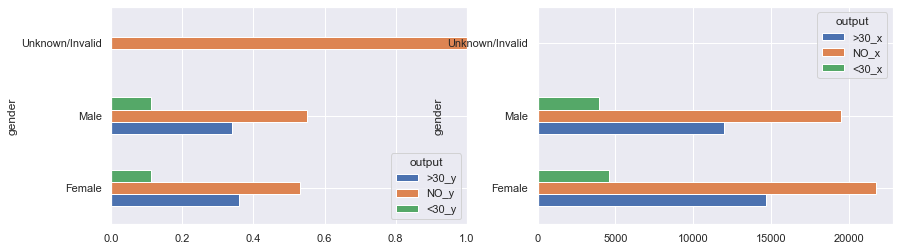

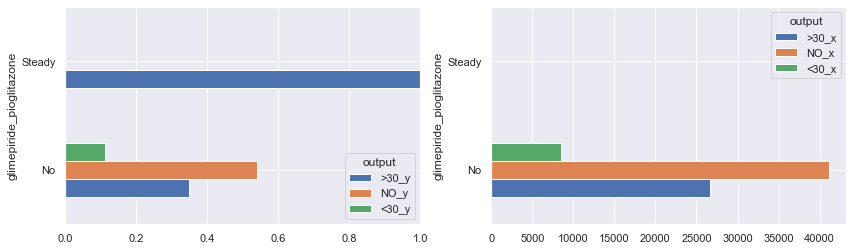

In [19]:
def get_frequency_by_output(X, y, col_name):
    freq_df = X.assign(output=y).groupby([col_name , "output"]).size().unstack().fillna(0)
    return freq_df.rename(columns={'No':'No_qnt','Yes':'Yes_qnt'}).merge(
        freq_df.divide(freq_df.sum(axis=1), axis=0), left_index=True, right_index=True
    )

object_cols = X_train_mod.dtypes[X_train_mod.dtypes=='object'].index.to_list()
for col_name in list(set(object_cols)-set(id_or_desc_cols)):
    pct_df = get_frequency_by_output(X_train_mod, y_train, col_name)
    #print("-"*10,col_name,"-"*10)
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    pct_df[columns_y].plot.barh(ax=ax[0])
    pct_df[columns_x].plot.barh(ax=ax[1])
    ax[0].set_xlim(0,1)

In [66]:
categorical_not_relevant = ["payer_code","repaglinide","nateglinide","chlorpropamide","acetohexamide","tolbutamide",
                            "acarbose","miglitol","troglitazone","tolazamide","examide","citoglipton",
                            "glipizide_metformin","glyburide_metformin","glimepiride_pioglitazone","metformin_rosiglitazone",
                            "metformin_pioglitazone"]
X_train_mod.drop(columns=categorical_not_relevant, inplace=True)
id_cols = ['encounter_id','patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
X_train_mod.drop(columns=id_cols, inplace=True)



### estudiar los nulos en el dataset

In [67]:
descr_df =  X_train_mod.describe(include=[object, int, float]).T
row_size = X_train_mod.shape[0]
descr_df[descr_df["count"] < row_size].dropna(axis=1).assign(null_percentage=(row_size-descr_df["count"])/row_size*100)

,count,mean,std,min,25%,50%,75%,max,null_percentage
weight,2395.0,73.538622,25.780508,0.0,50.0,75.0,100.0,200.0,96.862062


In [68]:
# None en campos categóricos
l = []
for col in object_cols:
    nones = X_train[X_train[col].str.lower().isin(["none", "?", "null", "unknow"])].shape[0]
    if nones>0:
        l.append({'column':col,'quantity':nones,'null_percentage': str(100*nones/X_train.shape[0])[:5]+'%'})
pd.DataFrame(l)

,column,quantity,null_percentage
0,race,1712,2.243%
1,payer_code,30223,39.59%
2,medical_specialty,37465,49.08%
3,diag_1,17,0.022%
4,diag_2,250,0.327%
5,diag_3,1064,1.394%
6,max_glu_serum,72336,94.77%
7,a1cresult,63571,83.29%
8,description_admision_source,5037,6.599%
9,description_admision_type,3914,5.128%




### estudiar los outliers

In [69]:
def outliers_plot(X, y, colname, false_y="No"):
    Q1=X[colname].quantile(0.25)
    Q3=X[colname].quantile(0.75)
    IQR = Q3 - Q1
    UpLim = Q3 + 1.5*IQR 
    DnLim = Q1 - 1.5*IQR
    outliers_df = X.assign(output=y)[(X[colname]>UpLim) | (X[colname]<DnLim)][[colname, "output"]]
    no_outliers_df = X.assign(output=y)[(X[colname]<=UpLim) & (X[colname]>=DnLim)][[colname, "output"]]
    fig, ax= plt.subplots(1,3, figsize=(20,5))
    ax[0].hist(outliers_df[outliers_df.output==false_y][colname], color='r', alpha=0.4)
    ax[0].hist(outliers_df[outliers_df.output!=false_y][colname], color='b', alpha=0.4)
    ax[1].hist(no_outliers_df[no_outliers_df.output==false_y][colname], color='r', alpha=0.4)
    ax[1].hist(no_outliers_df[no_outliers_df.output!=false_y][colname], color='b', alpha=0.4)
    ax[1].hist(outliers_df[outliers_df.output==false_y][colname], color='r', alpha=0.5)
    ax[1].hist(outliers_df[outliers_df.output!=false_y][colname], color='b', alpha=0.5)
    y_max = ax[1].get_ylim()[1]
    ax[1].plot([UpLim,UpLim],[0,y_max],'--g')
    ax[1].plot([DnLim,DnLim],[0,y_max],'--g')
    ax[0].set_title('Outliers Zoom')
    ax[0].set_ylabel(colname)
    ax[1].set_title('Original Distribution')
    ax[1].annotate('Upper\nLimit', xy=(UpLim, 0), xytext=(UpLim, .5), arrowprops=dict(facecolor='black', shrink=0.05))
    ax[1].annotate('Lower\nLimit', xy=(DnLim, 0), xytext=(DnLim, .5), arrowprops=dict(facecolor='black', shrink=0.05))
    ax[2].boxplot(X[colname], vert=False)
    y_max = ax[2].get_ylim()[1]
    ax[2].plot([UpLim,UpLim],[0,y_max],'--g')
    ax[2].plot([DnLim,DnLim],[0,y_max],'--g')
    ax[2].set_title('Distribution Boxplot')

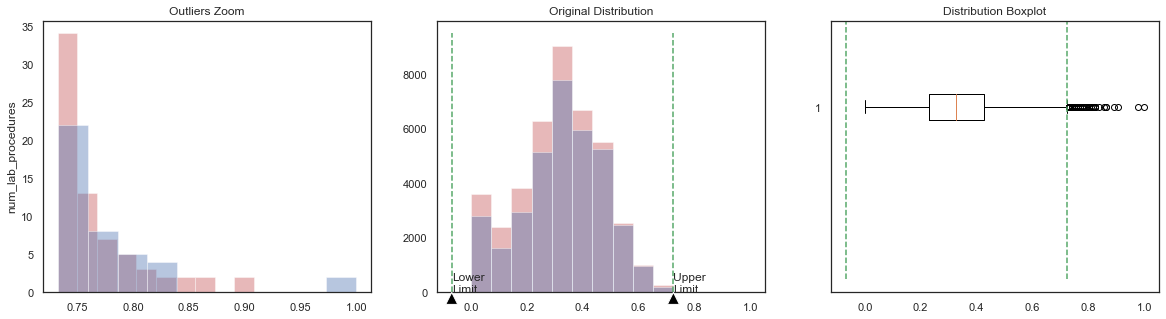

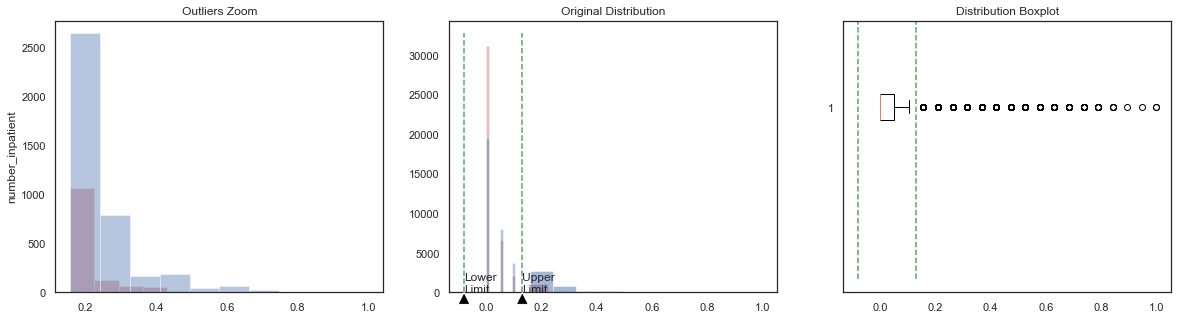

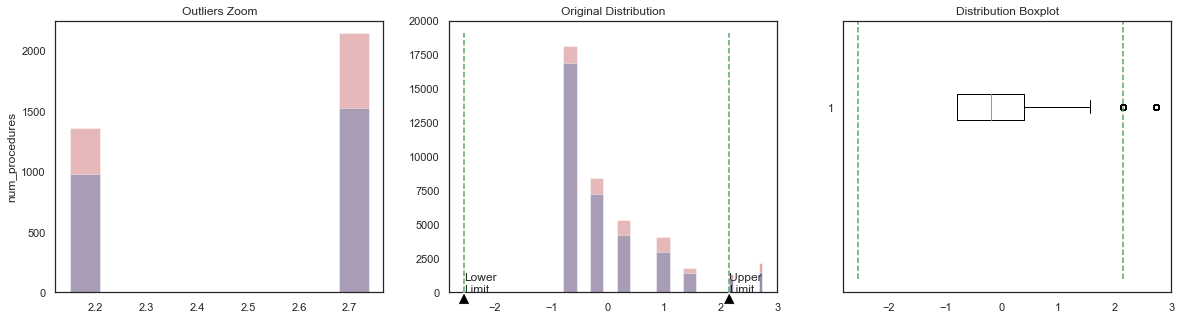

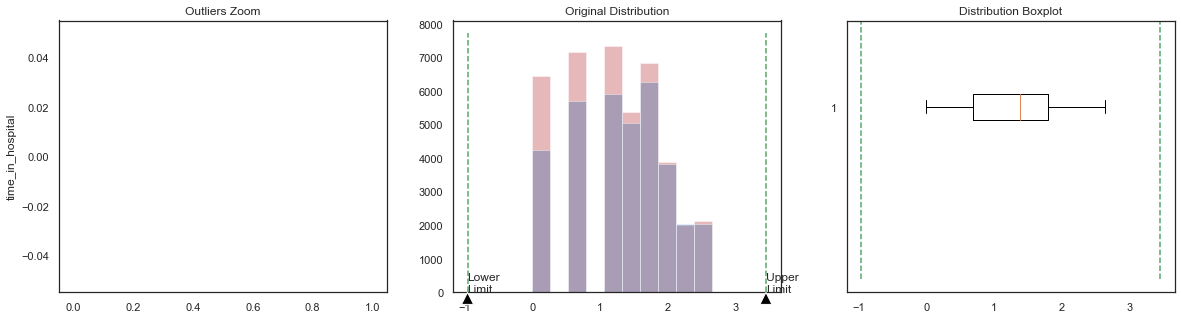

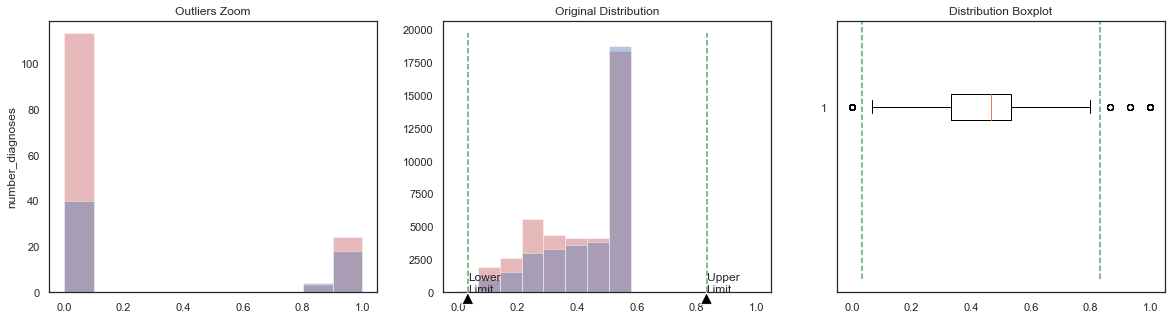

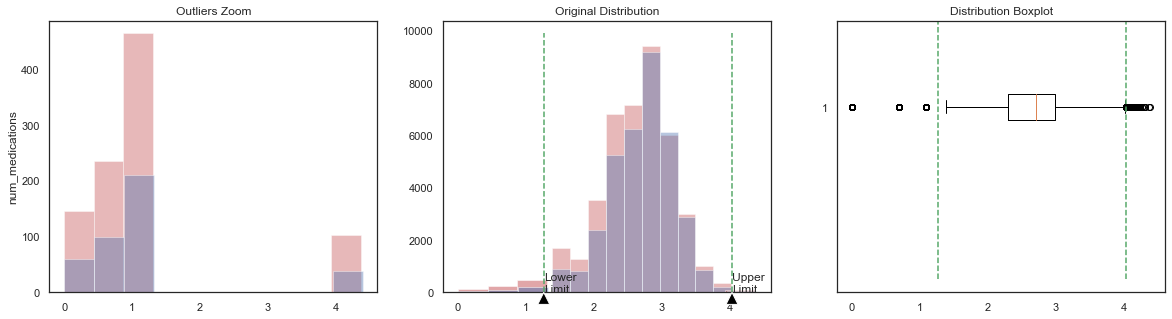

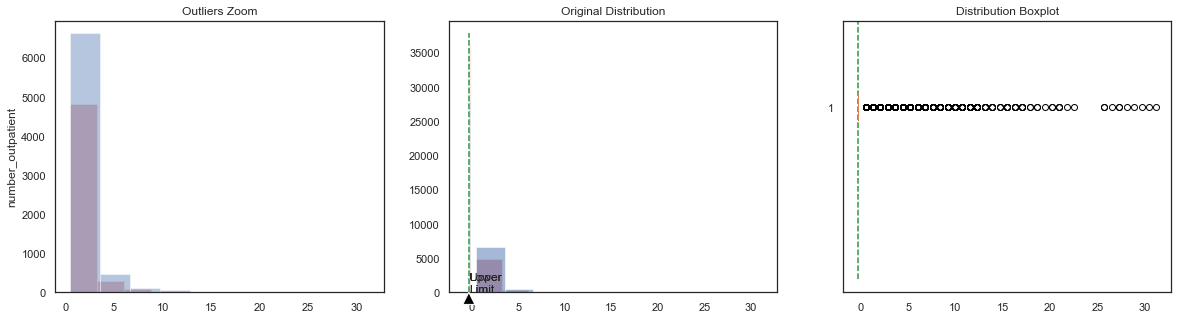

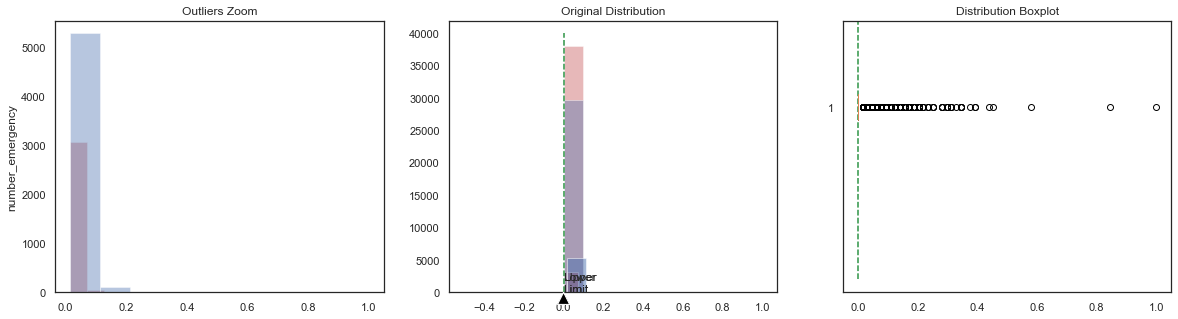

In [202]:
no_object_cols = list(set(X_train.dtypes[X_train.dtypes!=object].index.to_list()) - set(id_cols))
for colname in no_object_cols:
    try:
        outliers_plot(X_train_mod, y_train, colname, false_y="NO")
    except:
        print(colname)



### crear variables dummy en caso que sea conveniente



### antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear

In [71]:
get_frequency_by_output(X_train_mod, y_train, "description_admision_type")

output,<30_x,>30_x,NO_x,<30_y,>30_y,NO_y
description_admision_type,,,,,,
Elective,1474.0,4291.0,8363.0,0.104332,0.303723,0.591945
Emergency,4654.0,14474.0,21392.0,0.114857,0.357206,0.527937
Newborn,1.0,2.0,6.0,0.111111,0.222222,0.666667
None,446.0,1649.0,1819.0,0.113950,0.421308,0.464742
Not Available,367.0,1292.0,1920.0,0.102543,0.360995,0.536463
Not Mapped,19.0,58.0,157.0,0.081197,0.247863,0.670940
Trauma Center,0.0,0.0,12.0,0.000000,0.000000,1.000000
Urgent,1547.0,4861.0,7520.0,0.111071,0.349009,0.539920


In [72]:
X_train_mod = X_train_mod.assign(hospice_col=(X_train_mod.description_disposition.str.lower().str.contains('hospice')).astype(int))
get_frequency_by_output(X_train_mod, y_train, "hospice_col")

output,<30_x,>30_x,NO_x,<30_y,>30_y,NO_y
hospice_col,,,,,,
0,8479,26594,40661,0.111958,0.351150,0.536892
1,29,33,528,0.049153,0.055932,0.894915


In [73]:
def diagnosis_transforms(x):
    if x.startswith("E"):
        return "17"
    if x.startswith("V"):
        return "18"
    if "?" in x:
        return "others"
    new_x = int(('000' + x[:3])[-3:])
    if (1<=new_x & new_x<=139):
        return "1"
    if (140<=new_x & new_x<=239):
        return "2"
    if (240<=new_x & new_x<=279):
        return "3"
    if (280<=new_x & new_x<=289):
        return "4"
    if (290<=new_x & new_x<=319):
        return "5"
    if (320<=new_x & new_x<=389):
        return "6"
    if (390<=new_x & new_x<=459):
        return "7"
    if (460<=new_x & new_x<=519):
        return "8"
    if (520<=new_x & new_x<=579):
        return "9"
    if (580<=new_x & new_x<=629):
        return "10"
    if (630<=new_x & new_x<=679):
        return "11"
    if (680<=new_x & new_x<=709):
        return "12"
    if (710<=new_x & new_x<=739):
        return "13"
    if (740<=new_x & new_x<=759):
        return "14"
    if (760<=new_x & new_x<=779):
        return "15"
    if (780<=new_x & new_x<=799):
        return "16"
    if (800<=new_x & new_x<=999):
        return "17"
    

X_train_mod = X_train_mod.assign(
            diag_1=X_train_mod.diag_1.apply(diagnosis_transforms)
        ).assign(
            diag_2=X_train_mod.diag_2.apply(diagnosis_transforms)
        ).assign(
            diag_3=X_train_mod.diag_3.apply(diagnosis_transforms)
        )
X_train_mod = X_train_mod.assign(
            diag_12=(X_train_mod.diag_1==X_train.diag_2).astype(int)
        ).assign(
            diag_23=(X_train_mod.diag_2==X_train.diag_3).astype(int)
        )

In [74]:
X_train_mod[["diag_1","diag_2","diag_3", "diag_12", "diag_23"]].head()

,diag_1,diag_2,diag_3,diag_12,diag_23
83900,3,10,7,0,0
88539,9,3,7,0,0
19948,16,5,5,0,0
47364,1,3,12,0,0
42833,10,10,3,0,0


In [75]:
id_cols = ['encounter_id','patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
#X_train_mod.drop(columns=id_cols, inplace=True)
X_train_mod.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesmed',
       'description_admision_source', 'description_admision_type',
       'description_disposition', 'diag

In [76]:
X_train_mod = X_train_mod.assign(
            race_caucasian = (X.race=='Caucasian').astype(int)
        ).assign(
            race_african = (X.race=='AfricanAmerican').astype(int)
        ).assign(
            race_hispanic = (X.race=='Hispanic').astype(int)
        ).assign(
            gender_male = (X.gender=='Male').astype(int)
        ).assign(
            metformin = (X.metformin!='No').astype(int)
        ).assign(
            glimepiride = (X.glimepiride!='No').astype(int)
        ).assign(
            glipizide = (X.glipizide!='No').astype(int)
        ).assign(
            glyburide = (X.glyburide!='No').astype(int)
        ).assign(
            pioglitazone = (X.pioglitazone!='No').astype(int)
        ).assign(
            rosiglitazone = (X.rosiglitazone!='No').astype(int)
        ).assign(
            insulin = (X.insulin!='No').astype(int)
        ).assign(
            change = (X.change!='No').astype(int)
        ).assign(
            diabetesmed = (X.diabetesmed!='No').astype(int)
        ).assign(
            a1cresult_norm = (X.a1cresult=='Norm').astype(int)
        ).assign(
            a1cresult_upper = (X.a1cresult.str.startswith('>')).astype(int)
        ).assign(
            max_glu_serum_norm = (X.max_glu_serum=='Norm').astype(int)
        ).assign(
            max_glu_serum_upper = (X.max_glu_serum.str.startswith('>')).astype(int)
        ).drop(columns=["race", "gender", "weight","medical_specialty","a1cresult",
                    "description_admision_source","description_admision_type","description_disposition","max_glu_serum"
                   ])

In [86]:
#X_train_mod.drop(columns=categorical_not_relevant+id_cols, inplace=True)
pd.DataFrame([{'column_name':col,'values':X_train_mod[col].unique()} for col in X_train_mod.columns]) 

,column_name,values
0,age,"[30, 50, 40, 80, 60, 70, 90, 20, 10, 0]"
1,time_in_hospital,"[1, 2, 4, 3, 5, 13, 14, 8, 7, 6, 12, 9, 10, 11]"
2,num_lab_procedures,"[31, 26, 68, 10, 33, 1, 29, 23, 54, 56, 44, 63, 50, 27, 64, 66, 57, 30, 36, 40, 70, 21, 37, 59, 20, 52, 14, 53, 39, 82, 41, 51, 9, 15, 58, 35, 91, 5, 72, 19, 25, 43, 71, 60, 47, 45, 38, 65, 42, 18, 48, 17, 34, 12, 49, 22, 67, 28, 16, 62, 55, 8, 32, 73, 61, 3, 6, 2, 4, 74, 78, 46, 83, 79, 80, 69, 75, 88, 11, 76, 81, 90, 24, 86, 87, 77, 99, 13, 7, 89, 85, 102, 84, 106, 94, 101, 97, 98, 92, 95, ...]"
3,num_procedures,"[1, 3, 0, 2, 4, 5, 6]"
4,num_medications,"[12, 5, 11, 6, 16, 7, 14, 13, 15, 3, 21, 10, 26, 34, 18, 23, 19, 20, 9, 22, 33, 25, 8, 53, 17, 31, 30, 37, 28, 35, 27, 24, 36, 45, 4, 40, 38, 29, 44, 2, 39, 32, 46, 49, 1, 48, 50, 58, 56, 47, 41, 55, 51, 54, 43, 42, 67, 52, 62, 68, 63, 59, 66, 65, 61, 69, 57, 64, 60, 81, 75, 72, 79, 70, 74]"
5,number_outpatient,"[1, 0, 2, 4, 3, 22, 5, 7, 16, 6, 10, 34, 8, 13, 20, 24, 12, 9, 19, 29, 11, 14, 33, 17, 27, 15, 36, 21, 23, 28, 18, 35, 25, 38, 26, 37, 39, 40]"
6,number_emergency,"[1, 0, 2, 3, 6, 4, 9, 5, 15, 7, 8, 10, 11, 24, 18, 21, 22, 13, 12, 28, 19, 16, 20, 14, 64, 29, 25, 37, 54]"
7,number_inpatient,"[2, 0, 1, 3, 9, 4, 7, 8, 5, 6, 10, 11, 15, 12, 16, 13, 14, 17, 18, 19]"
8,diag_1,"[3, 9, 16, 1, 10, 5, 11, 8, 7, 17, 13, 6, 18, 2, 12, 4, 14, others]"
9,diag_2,"[10, 3, 5, 6, 11, 8, 7, 18, 2, 16, 12, 9, 17, 14, 4, 13, 1, others]"


In [87]:
X_train_mod = X_train_mod.assign(age=(X_train_mod.age/100)+0.05)

In [88]:
"""
1 	time_in_hospital 	[1, 2, 4, 3, 5, 13, 14, 8, 7, 6, 12, 9, 10, 11]
2 	num_lab_procedures 	[31, 26, 68, 10, 33, 1, 29, 23, 54, 56, 44, 63, 50, 27, 64, 66, ...]
3 	num_procedures 	[1, 3, 0, 2, 4, 5, 6]
4 	num_medications 	[12, 5, 11, 6, 16, 7, 14, 13, 15, 3, 21, 10, 26, 34, 18, 23, 19, ...]
5 	number_outpatient 	[1, 0, 2, 4, 3, 22, 5, 7, 16, 6, 10, 34, 8, 13, 20, 24, 12, 9, 19, ...]
6 	number_emergency 	[1, 0, 2, 3, 6, 4, 9, 5, 15, 7, 8, 10, 11, 24, 18, 21, 22, 13, 12, 28, ...]
7 	number_inpatient 	[2, 0, 1, 3, 9, 4, 7, 8, 5, 6, 10, 11, 15, 12, 16, 13, 14, 17, 18, 19]
8 	diag_1 	[3, 9, 16, 1, 10, 5, 11, 8, 7, 17, 13, 6, 18, 2, 12, 4, 14, others]
9 	diag_2 	[10, 3, 5, 6, 11, 8, 7, 18, 2, 16, 12, 9, 17, 14, 4, 13, 1, others]
10 	diag_3 	[7, 5, 12, 3, 11, 16, 10, 6, 8, 17, 1, 18, 2, others, 9, 4, 13, 14]
11 	number_diagnoses 	[9, 8, 3, 6, 7, 4, 5, 2, 1, 10, 16, 12, 13, 15, 14, 11]
"""
estandarize_cols = ["time_in_hospital","num_lab_procedures","num_procedures","num_medications",
    "number_outpatient","number_emergency","number_inpatient","number_diagnoses"]
#X_train_mod[["diag_1", "diag_2", "diag_3"]]
from sklearn.preprocessing import OneHotEncoder
diag_cols = ["diag_1", "diag_2", "diag_3"]
ohenc_diag = OneHotEncoder(drop='first',dtype=int)
X_train_mod.loc[:,ohenc_diag.get_feature_names(diag_cols)] = ohenc_diag.fit_transform(X_train_mod[diag_cols]).toarray()
X_train_mod.columns

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesmed', 'diag_12',
       'diag_23', 'race_caucasian', 'race_african', 'race_hispanic',
       'gender_male', 'a1cresult_norm', 'a1cresult_upper',
       'max_glu_serum_norm', 'max_glu_serum_upper', 'diag_1_10', 'diag_1_11',
       'diag_1_12', 'diag_1_13', 'diag_1_14', 'diag_1_16', 'diag_1_17',
       'diag_1_18', 'diag_1_2', 'diag_1_3', 'diag_1_4', 'diag_1_5', 'diag_1_6',
       'diag_1_7', 'diag_1_8', 'diag_1_9', 'diag_1_others', 'diag_2_10',
       'diag_2_11', 'diag_2_12', 'diag_2_13', 'diag_2_14', 'diag_2_16',
       'diag_2_17', 'diag_2_18', 'diag_2_2', 'diag_2_3', 'diag_2_4',
       'diag_2_5', 'diag_2_6', 'diag_2_7', 'diag_2_8', 'diag_2



# Exploratory Data Analysis



### crear la matriz de correlación

<AxesSubplot:>

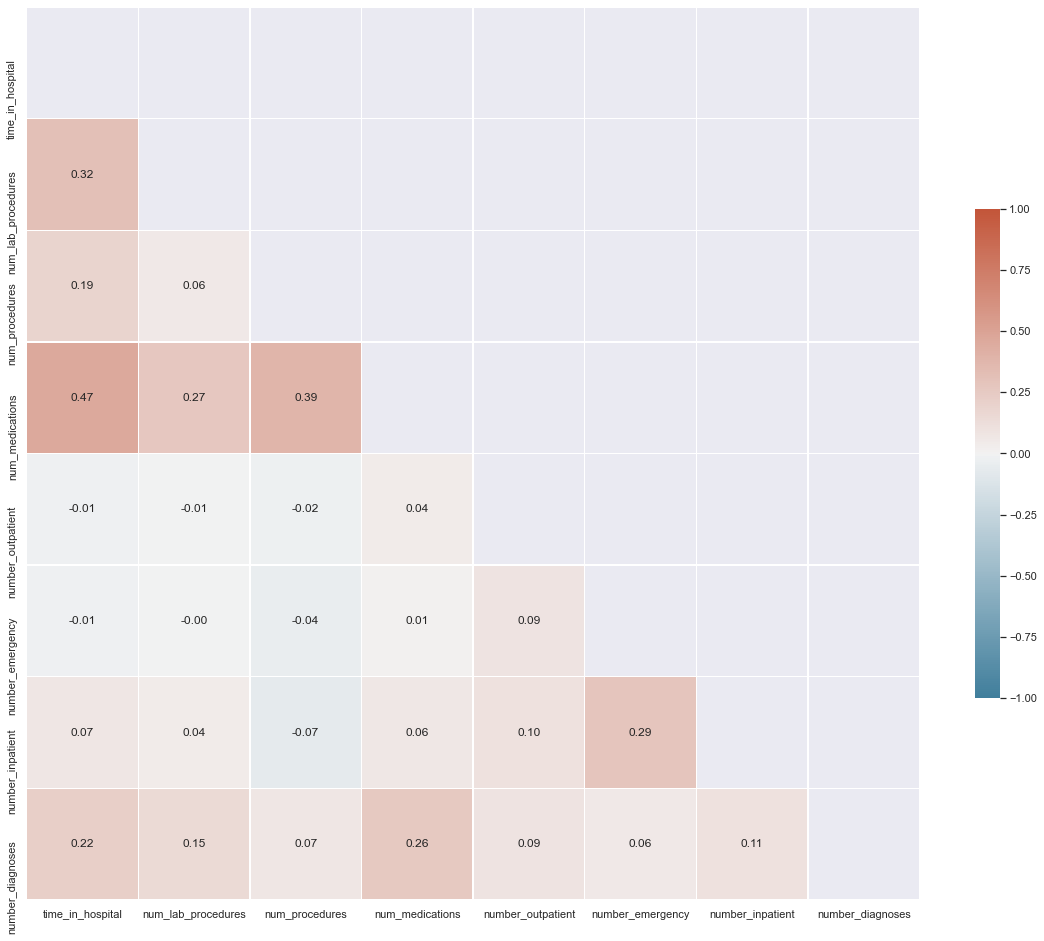

In [89]:
estandarize_cols = ["time_in_hospital","num_lab_procedures","num_procedures","num_medications",
    "number_outpatient","number_emergency","number_inpatient","number_diagnoses"]
corr = X_train_mod[estandarize_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 18))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

<AxesSubplot:xlabel='num_medications', ylabel='time_in_hospital'>

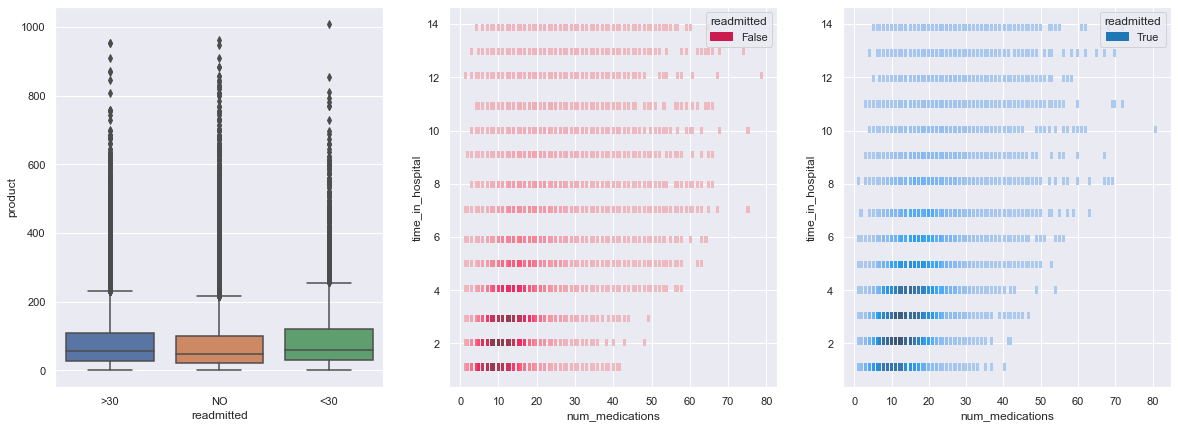

In [90]:
tmp = pd.DataFrame().assign(
    product=X_train_mod["num_medications"].multiply(X_train_mod["time_in_hospital"])
    ).assign(readmitted=y_train)
fig, ax = plt.subplots(1,3, figsize=(20,7))
sns.boxplot(data=tmp, x="readmitted", y="product", ax=ax[0])
#sns.histplot(data=tmp, x="product", hue="readmitted", ax=ax[1], multiple="stack", element="step", cumulative=False, fill=False)
tmp = X_train_mod.assign(readmitted=y_train!="NO")
sns.histplot(tmp[~tmp["readmitted"]], 
             x="num_medications", y="time_in_hospital", hue="readmitted", ax=ax[1], log_scale=(False,False), palette='rocket')
sns.histplot(tmp[tmp["readmitted"]], 
             x="num_medications", y="time_in_hospital", hue="readmitted", ax=ax[2], log_scale=(False,False), palette='tab10')



### determinar qué par de variables están correlacionadas

In [91]:
limit_ = 0.6
corr = X_train_mod.corr()
for i in range(corr.shape[0]):
    corr.iloc[i,i:] = 0
corr[(corr>=limit_) | (corr<=-limit_)].dropna(axis=1, how='all').stack()

race_african  race_caucasian   -0.828859
diag_2_11     diag_1_11         0.776466
diag_3_11     diag_1_11         0.652543
dtype: float64



### estudiar los pares de variables correlacionadas para quedarse solamente con una del par

Consideramos no bajarnos por que race, tenemos race: caucasico, african, hipanico y others

In [92]:
#diagnosito-11: "Condiciones de Embarazo"
X_train_mod.drop(columns=["diag_2_11", "diag_3_11"], inplace=True)



# Modelado



### seleccionar variables

In [93]:
from sklearn.preprocessing import OneHotEncoder
def clean(X_, label_encoder=None):
    X = X_.copy()
    X = X.assign(
            age = X.age.apply(lambda x: int(x.replace("[","").replace(")","").split("-")[0]))
        ).assign(
            weight = X.weight.apply(lambda x: np.nan if x=='?' else int(x.replace("[","").replace(")","").replace(">","").split("-")[0]))
        )
    X = X.assign(
        age = (X.age/100) + 0.05
    )
    categorical_not_relevant = ["payer_code","repaglinide","nateglinide","chlorpropamide","acetohexamide","tolbutamide","acarbose",#max_glu_serum
        "miglitol","troglitazone","tolazamide","examide","citoglipton","glipizide_metformin","glyburide_metformin",
        "glimepiride_pioglitazone","metformin_rosiglitazone","metformin_pioglitazone", "weight"] #~weight
    X.drop(columns=categorical_not_relevant, inplace=True)
    id_cols = ['encounter_id','patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
    X.drop(columns=id_cols, inplace=True)

    X = X.assign(
            race_caucasian = (X.race=='Caucasian').astype(int)
        ).assign(
            race_african = (X.race=='AfricanAmerican').astype(int)
        ).assign(
            race_hispanic = (X.race=='Hispanic').astype(int)
        ).assign(
            gender_male = (X.gender=='Male').astype(int)
        ).assign(
            metformin = (X.metformin!='No').astype(int)
        ).assign(
            glimepiride = (X.glimepiride!='No').astype(int)
        ).assign(
            glipizide = (X.glipizide!='No').astype(int)
        ).assign(
            glyburide = (X.glyburide!='No').astype(int)
        ).assign(
            pioglitazone = (X.pioglitazone!='No').astype(int)
        ).assign(
            rosiglitazone = (X.rosiglitazone!='No').astype(int)
        ).assign(
            insulin = (X.insulin!='No').astype(int)
        ).assign(
            change = (X.change!='No').astype(int)
        ).assign(
            diabetesmed = (X.diabetesmed!='No').astype(int)
        ).assign(
            a1cresult_norm = (X.a1cresult=='Norm').astype(int)
        ).assign(
            a1cresult_upper = (X.a1cresult.str.startswith('>')).astype(int)
        ).assign(
            max_glu_serum_norm = (X.max_glu_serum=='Norm').astype(int)
        ).assign(
            max_glu_serum_upper = (X.max_glu_serum.str.startswith('>')).astype(int)
        ).assign(
            hospice_disposition = (X.description_disposition.str.lower().str.contains('hospice')).astype(int)
    ).drop(columns=["race", "gender","medical_specialty","a1cresult","max_glu_serum",
                    "description_admision_source","description_admision_type","description_disposition"
                   ])# max_glu_serum=None & toman medicamento_diabetes->
    X = X.assign(
            diag_1=X.diag_1.apply(diagnosis_transforms)
        ).assign(
            diag_2=X.diag_2.apply(diagnosis_transforms)
        ).assign(
            diag_3=X.diag_3.apply(diagnosis_transforms)
        )
    X = X.assign(
            diag_12=(X.diag_1==X.diag_2).astype(int)
        ).assign(
            diag_23=(X.diag_2==X.diag_3).astype(int)
        )
    diag_cols = ["diag_1", "diag_2", "diag_3"]
    is_training = (label_encoder==None)
    if is_training:
        label_encoder = OneHotEncoder(drop='first',dtype=int)
        X.loc[:,label_encoder.get_feature_names(diag_cols)] = label_encoder.fit_transform(X[diag_cols]).toarray()
    else:
        X.loc[:,label_encoder.get_feature_names(diag_cols)] = label_encoder.transform(X[diag_cols]).toarray()
    X.drop(columns=diag_cols+["diag_2_11", "diag_3_11"], inplace=True)

    return (X, label_encoder) if is_training else X

In [94]:
X_train_clean, ohenc_diag = clean(X_train)
X_test_clean = clean(X_test, ohenc_diag)

In [95]:
X_train_clean.shape, X_test_clean.shape

((76324, 78), (25442, 78))

In [96]:
limit_ = 0.6
corr = X_train_clean.corr()
for i in range(corr.shape[0]):
    corr.iloc[i,i:] = 0
corr[(corr>=limit_) | (corr<=-limit_)].dropna(axis=1, how='all').stack()

race_african  race_caucasian   -0.828859
dtype: float64



### estandarizar variables

num_procedures  log with infinites 
number_outpatient  log with infinites 
number_emergency  log with infinites 
number_inpatient  log with infinites 


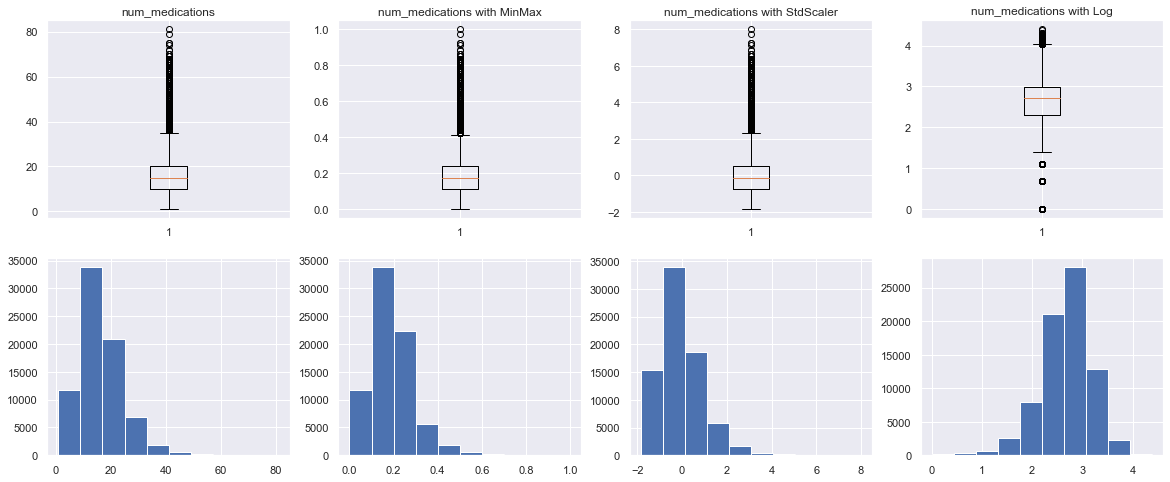

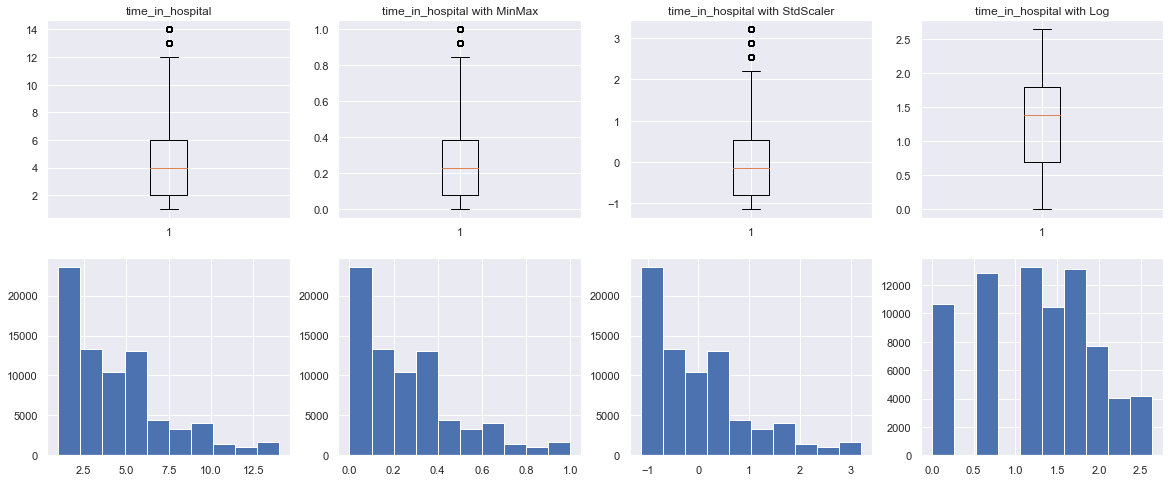

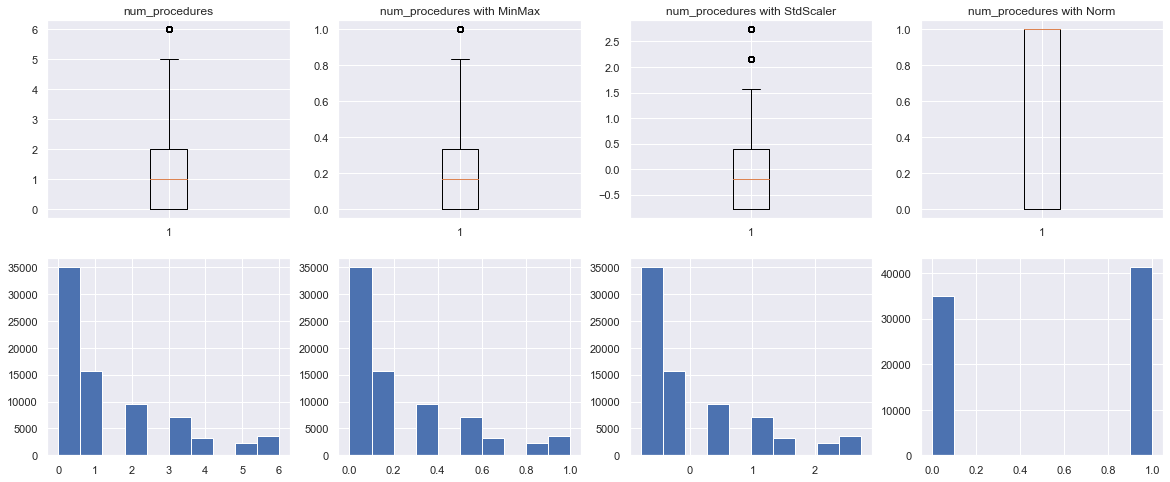

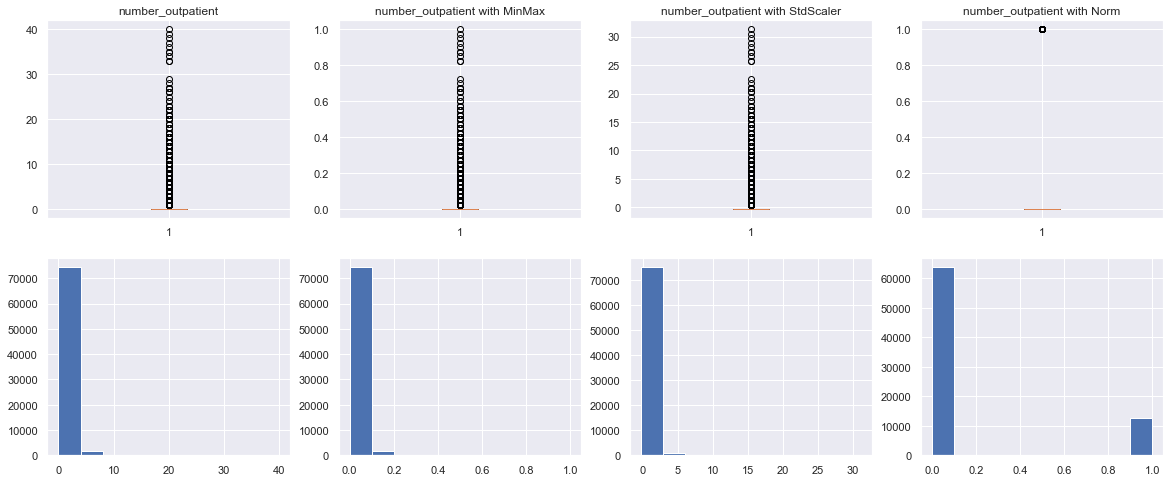

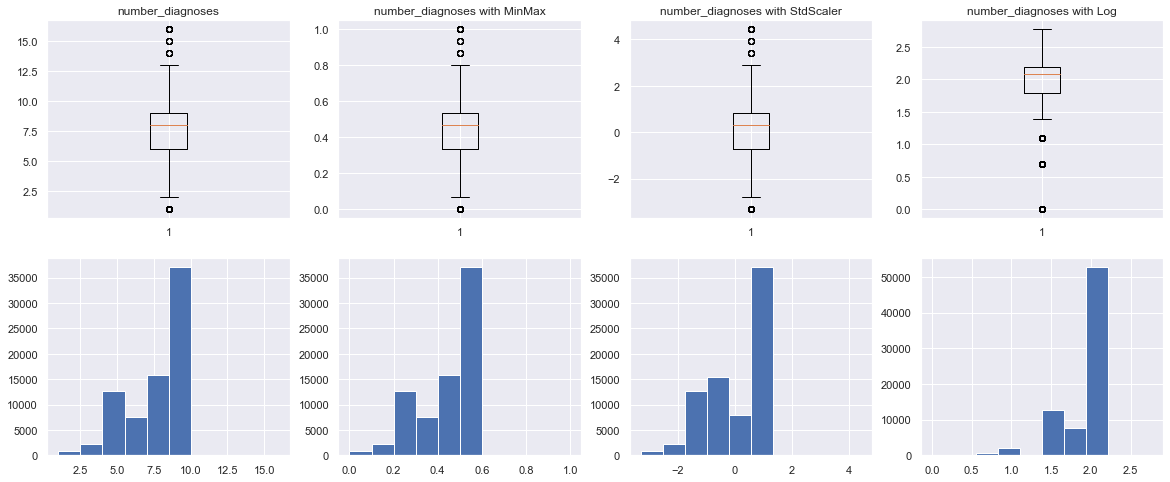

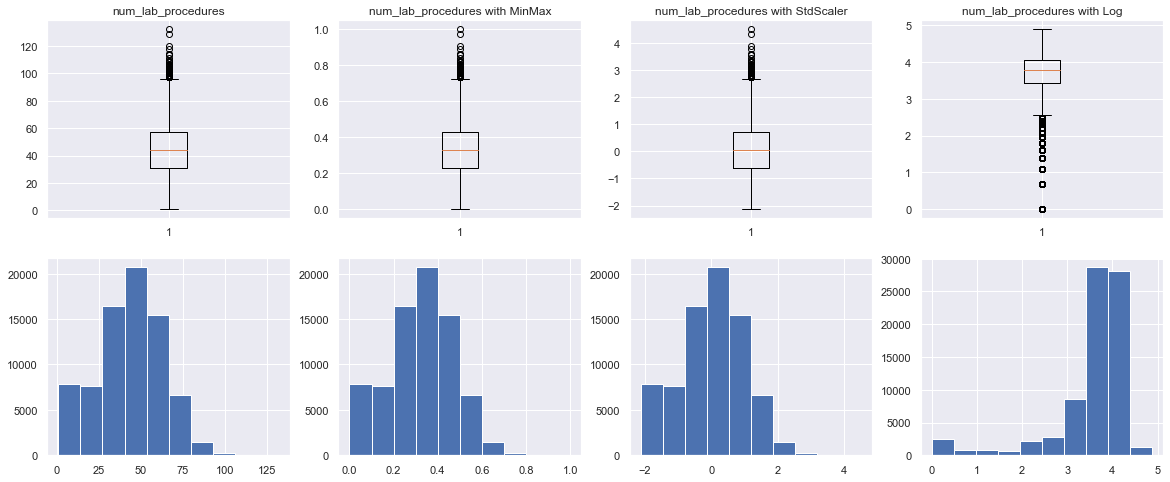

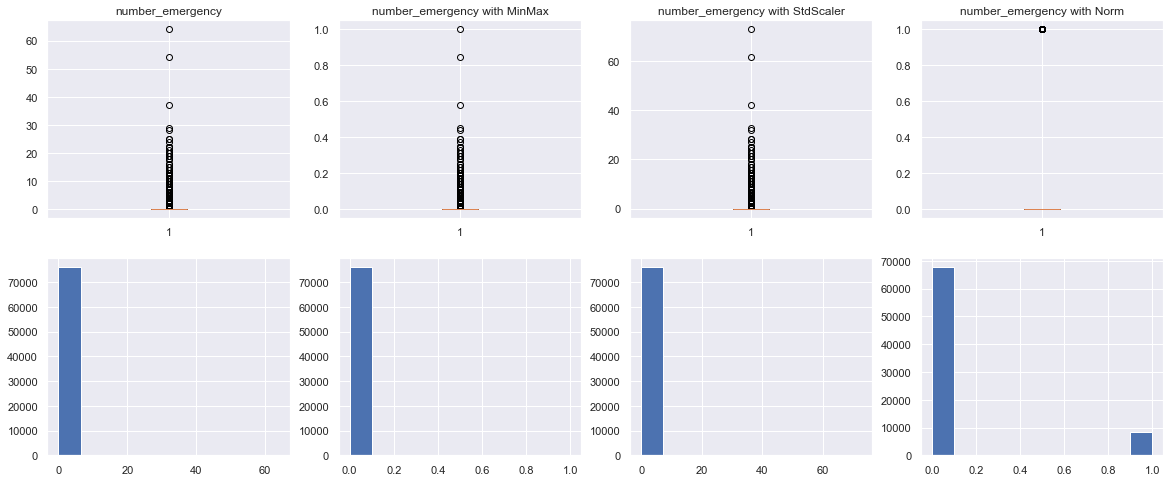

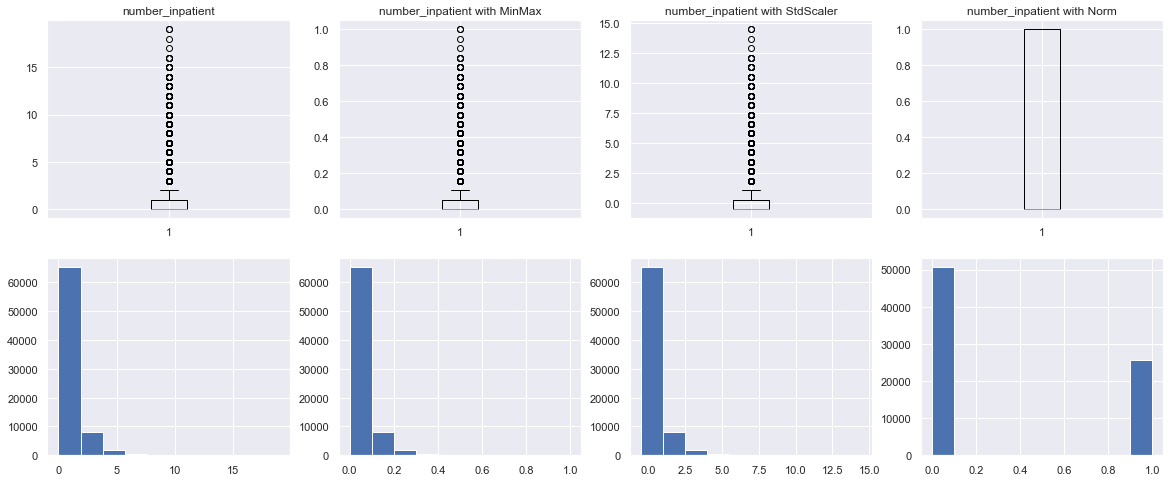

In [98]:
from sklearn import preprocessing

def plot_scalation(X, colname):
    normalizer = preprocessing.Normalizer()
    std_scaler = preprocessing.StandardScaler()
    min_max_scaler = preprocessing.MinMaxScaler()
    fig,ax = plt.subplots(2,4, figsize=(20,8))
    ax[0,0].boxplot(X[colname])
    ax[1,0].hist(X[colname])
    ax[0,0].set_title(colname)
    new_values_mm = min_max_scaler.fit_transform(X[colname].values.reshape(-1,1))
    ax[0,1].boxplot(new_values_mm)
    ax[1,1].hist(new_values_mm)
    ax[0,1].set_title(colname+' with MinMax')
    new_values_std = std_scaler.fit_transform(X[colname].values.reshape(-1,1))
    ax[0,2].boxplot(new_values_std)
    ax[1,2].hist(new_values_std)
    ax[0,2].set_title(colname+' with StdScaler')
    if 0 not in X[colname].unique():
        new_values_log = np.log(X[colname])
        ax[0,3].boxplot(new_values_log)
        ax[1,3].hist(new_values_log)
        ax[0,3].set_title(colname+' with Log')
    else:
        new_values_norm = normalizer.fit_transform(X[colname].values.reshape(-1,1))
        ax[0,3].boxplot(new_values_norm)
        ax[1,3].hist(new_values_norm)
        ax[0,3].set_title(colname+' with Norm')
        print(colname, " log with infinites ")

#colname = "num_medications" # number_diagnoses | num_procedures
numeric_cols = ["num_medications", "time_in_hospital","num_procedures", "number_outpatient","number_diagnoses",
                "num_lab_procedures","number_emergency","number_inpatient"]
for col in numeric_cols:
    plot_scalation(X_train, col)

In [99]:
std_scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
#X.loc[:,label_encoder.get_feature_names(diag_cols)]
log_apply_cols = ["num_medications", "time_in_hospital"]
std_apply_cols = ["num_procedures", "number_outpatient"]
mm_apply_cols = ["number_diagnoses", "num_lab_procedures", "number_emergency", "number_inpatient"]
std_scaler.fit(X_train_mod[std_apply_cols])
min_max_scaler.fit(X_train_mod[mm_apply_cols])

MinMaxScaler()

In [100]:
X_train_mod.loc[:,log_apply_cols] = np.log(X_train_mod[log_apply_cols])
X_train_mod.loc[:,std_apply_cols] = std_scaler.transform(X_train_mod[std_apply_cols])
X_train_mod.loc[:,mm_apply_cols] = min_max_scaler.transform(X_train_mod[mm_apply_cols])

In [101]:
def apply_scale(X_, scalers={}):
    X = X_.copy()
    std_scaler = scalers['std']
    min_max_scaler = scalers['mm']
    X.loc[:,log_apply_cols] = np.log(X[log_apply_cols])
    X.loc[:,std_apply_cols] = std_scaler.transform(X[std_apply_cols])
    X.loc[:,mm_apply_cols] = min_max_scaler.transform(X[mm_apply_cols])
    return X

In [102]:
X_train_clean = apply_scale(X_train_clean, {'std': std_scaler, 'mm': min_max_scaler})
X_test_clean = apply_scale(X_test_clean, {'std': std_scaler, 'mm': min_max_scaler})



### lanzar distintos algoritmos

In [175]:
seed = 8
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold

def reliability_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[1][1]/(cm[1][1] + cm[0][1])
def sensibility_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[1][1]/(cm[1][1]+cm[1][0])
def precision_macro(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro')
def precision_micro(y_true, y_pred):
    return precision_score(y_true, y_pred, average='micro')
def precision_weighted(y_true, y_pred):
    return precision_score(y_true, y_pred, average='weighted')

def model_evaluation(model, X_train, y_train, X_test, y_test, cv=5, model_name='model name'):
    scoring_ = {
            'f1': 'f1',
            'f1_macro': 'f1_macro',
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'auc': 'roc_auc',
            'precision_macro': make_scorer(precision_macro),
            'precision_weighted': make_scorer(precision_weighted),
            'sensibility': 'recall',
            'reliability': make_scorer(reliability_score)
          }
    # Cross results
    cv_r = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring_, n_jobs=-1)
    df_cv = pd.DataFrame(
            cv_r
          ).rename(
            columns=dict(zip(map(lambda x:'test_'+x, scoring_.keys()), scoring_.keys()))
          ).drop(
            columns=["fit_time", "score_time"]
          ).fillna(0)
    # Training - Testing - Evaluation Results
    model.fit(X_train, y_train)
    y_pred_50 = model.predict(X_test)
    cm_df_50 = confusion_matrix(y_test, y_pred_50)
    sensibility_per_str = str(sensibility_score(y_test, y_pred_50)*100)[:5]+"%"
    reliability_per_str = str(reliability_score(y_test, y_pred_50)*100)[:5]+"%"
    # Printing Results
    # Plotting Results
    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    df_cv.boxplot(vert=False, ax=ax[0])
    #classes_ = ["<30",">30","No"]
    sns.heatmap(cm_df_50, ax=ax[1], cmap='Blues', fmt='d', annot=True, cbar=True)#, xticklabels=classes_, yticklabels=classes_)
    ax[0].set_title('Cross Validation: Train Data')
    ax[0].set_ylabel(model_name) #model.__class__.__name__)
    ax[1].set_title('Confusion Matrix: Testing Data')
    ax[1].set_xlabel(f'Predicted\nSensibility:{sensibility_per_str}  Reliability:{reliability_per_str})')
    ax[1].set_ylabel('Real')



### evaluar los algoritmos para determinar cuál es el que mejor

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
seed=10
cv_splits=10

In [134]:
X_train_clean, ohenc = clean(X_train)
X_train_clean = apply_scale(X_train_clean, {'std': std_scaler, 'mm': min_max_scaler})
X_test_clean = clean(X_test, ohenc)
X_test_clean = apply_scale(X_test_clean, {'std': std_scaler, 'mm': min_max_scaler})
y_train_binomial = (y_train!="NO").astype(int)
y_test_binomial = (y_test!="NO").astype(int)

#### Testing Dummmy Classifiers

<ipython-input-143-df7ed53337a8>:10: RuntimeWarning: invalid value encountered in long_scalars
  return cm[1][1]/(cm[1][1] + cm[0][1])
<ipython-input-143-df7ed53337a8>:10: RuntimeWarning: invalid value encountered in long_scalars
  return cm[1][1]/(cm[1][1] + cm[0][1])


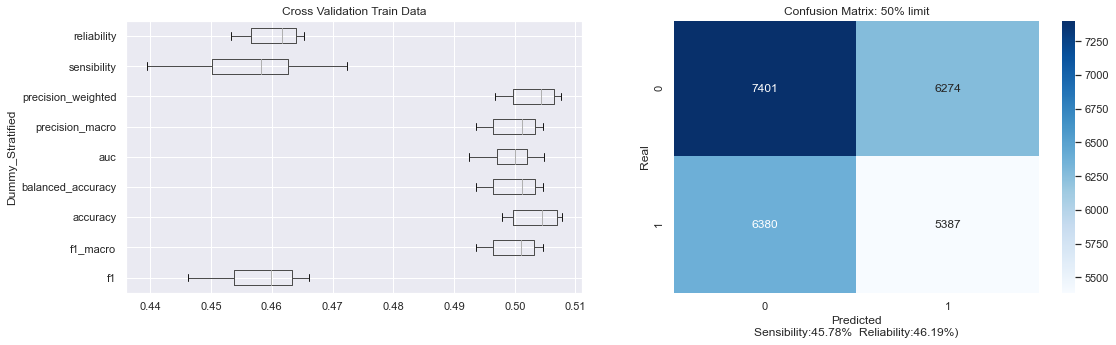

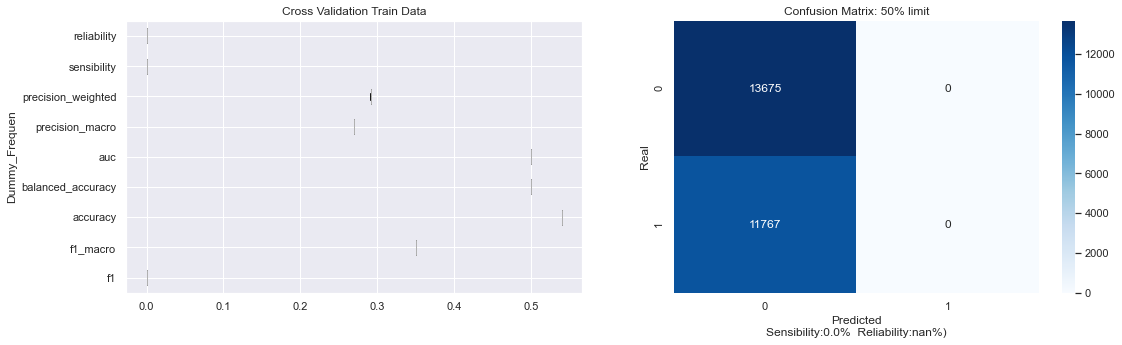

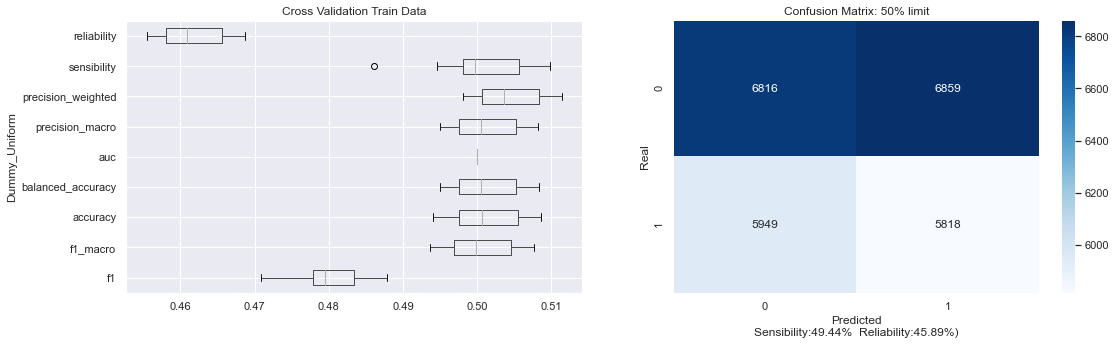

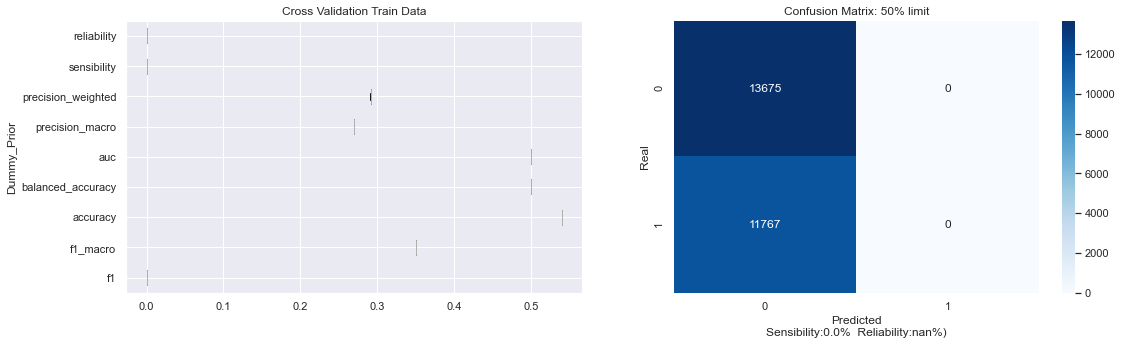

In [145]:
dummy_list = [
              ('Dummy_Stratified',DummyClassifier(strategy='stratified')),
              ('Dummy_Frequen',DummyClassifier(strategy='most_frequent')), 
              ('Dummy_Uniform',DummyClassifier(strategy='uniform')),
              ('Dummy_Prior',DummyClassifier(strategy='prior'))
             ]
for name, model in dummy_list:
    model_evaluation(model, 
                      X_train_clean, y_train_binomial, 
                      X_test_clean, y_test_binomial, 
                      cv=StratifiedKFold(n_splits=cv_splits),
                      model_name=name
                  )

#### Logistic Regression

/Users/ohuarcaya/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ohuarcaya/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

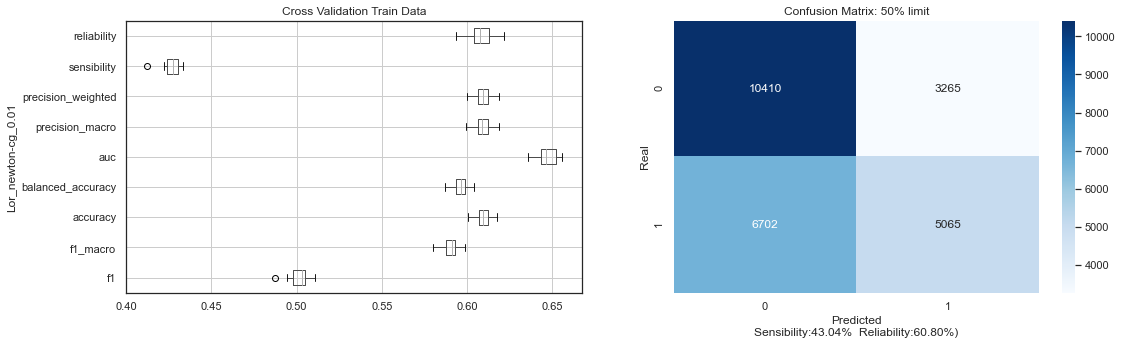

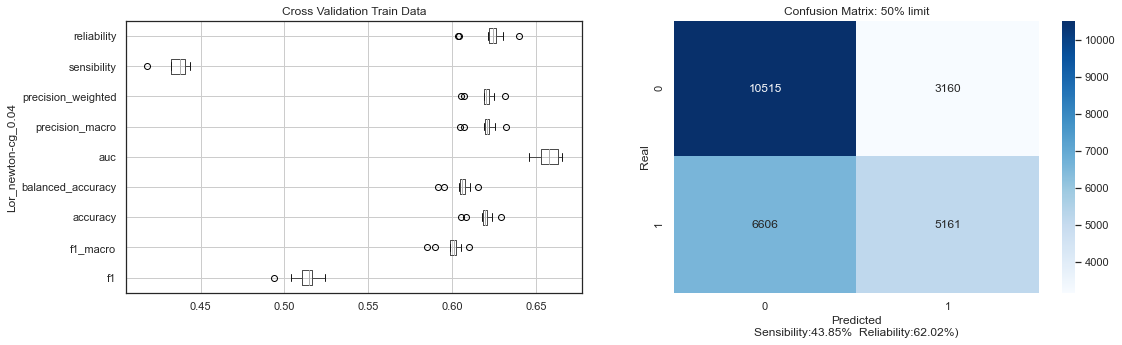

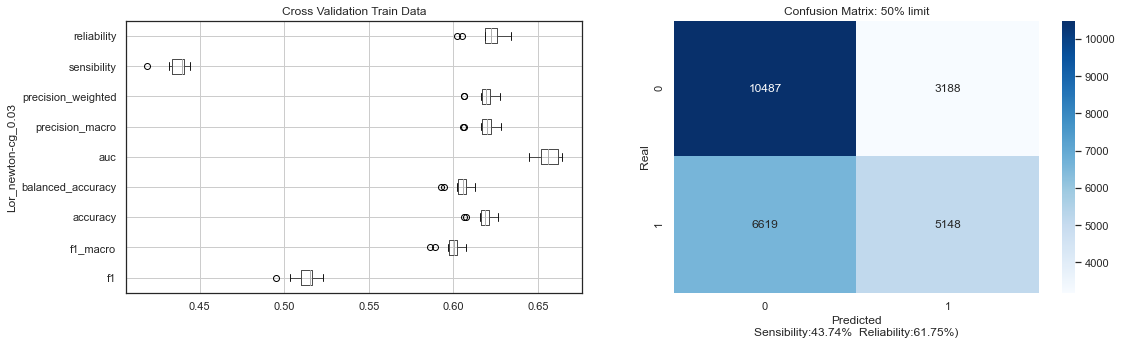

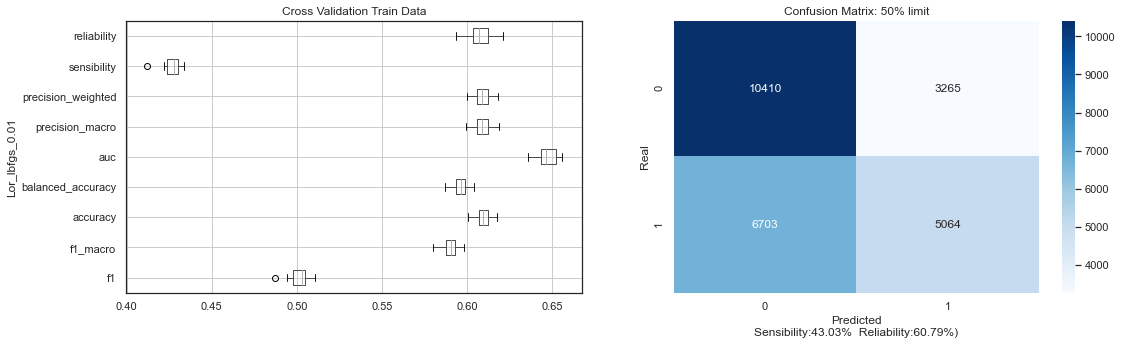

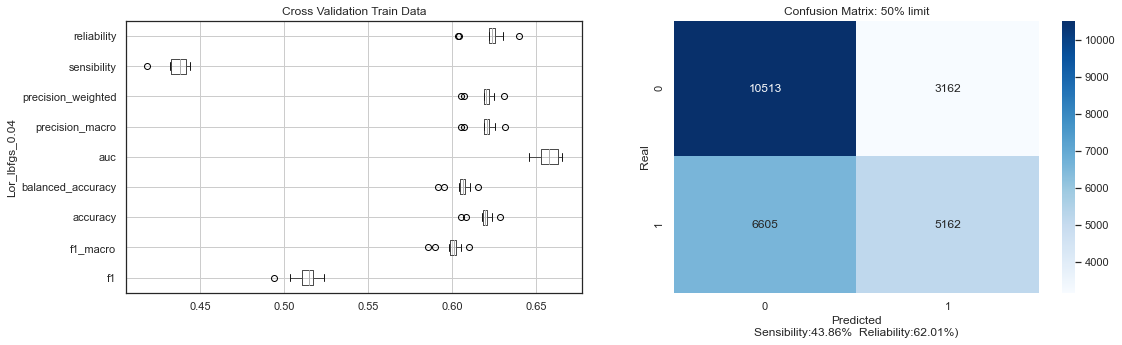

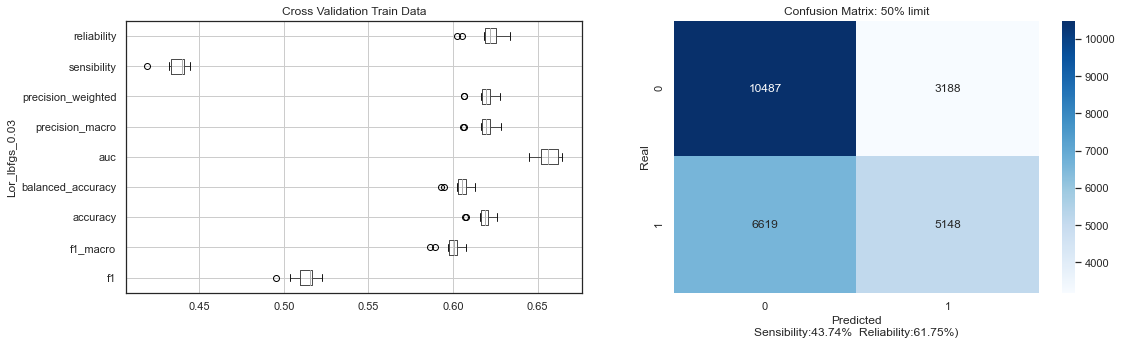

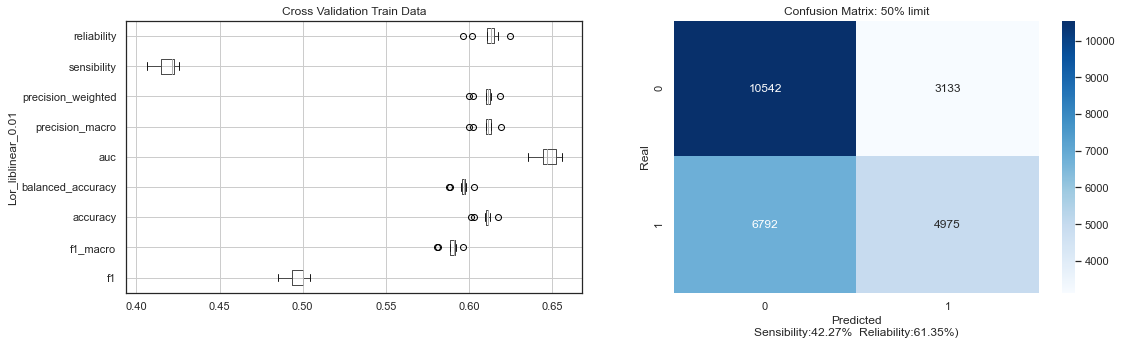

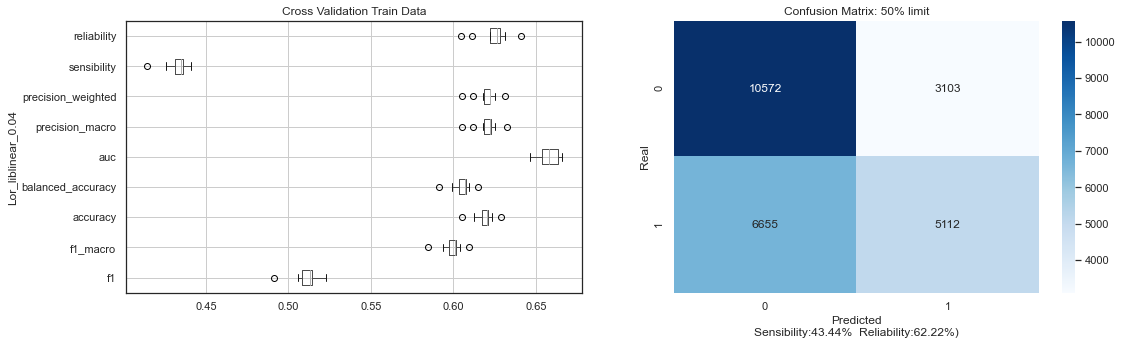

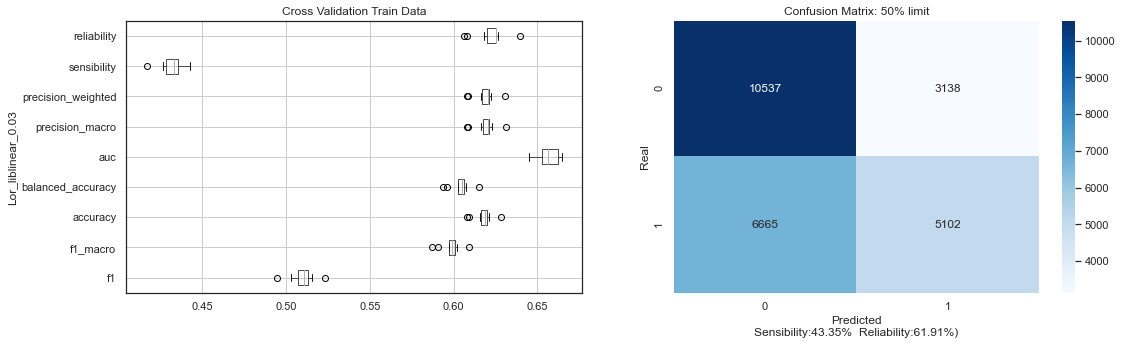

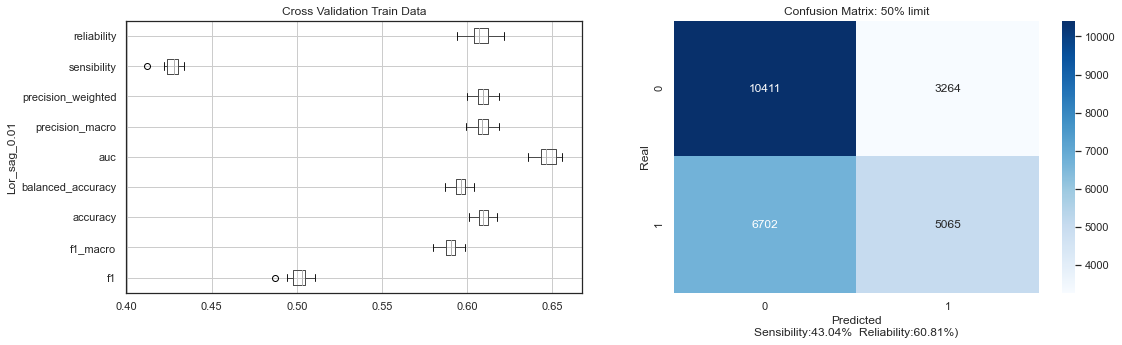

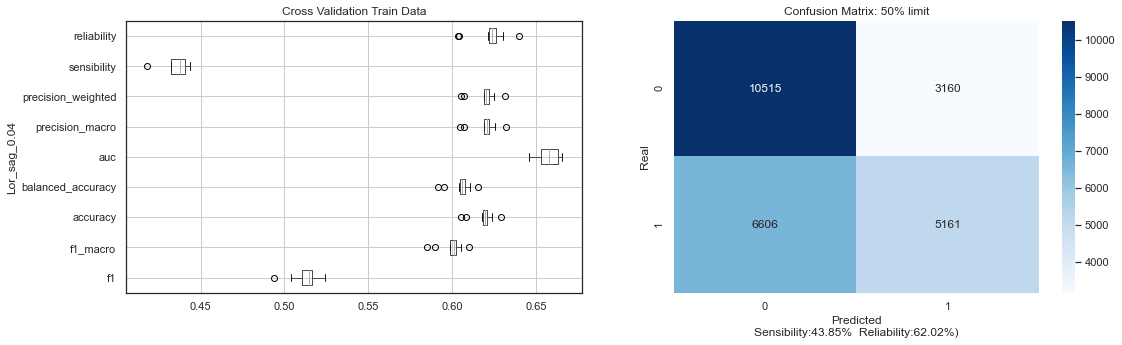

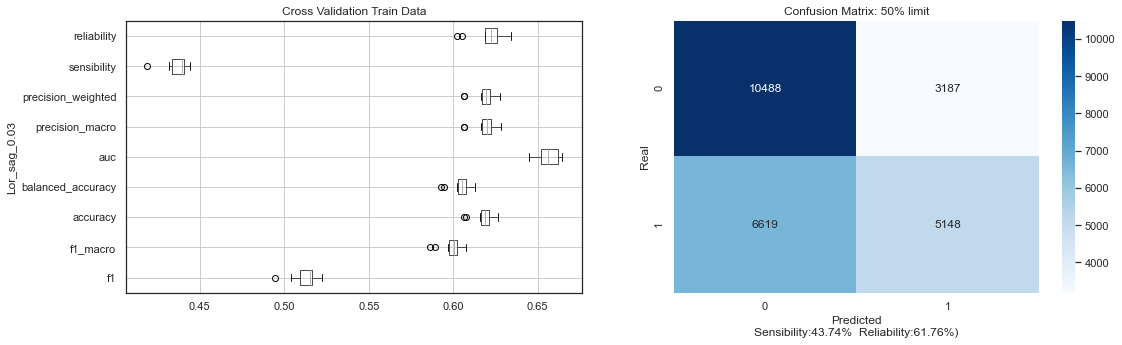

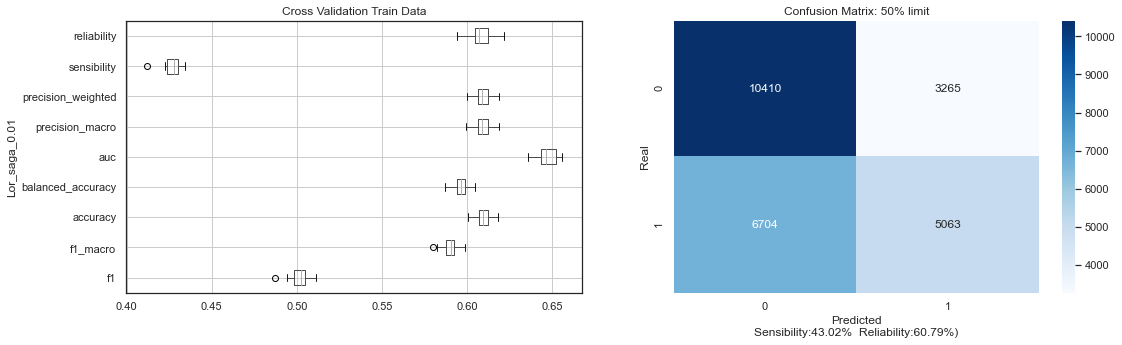

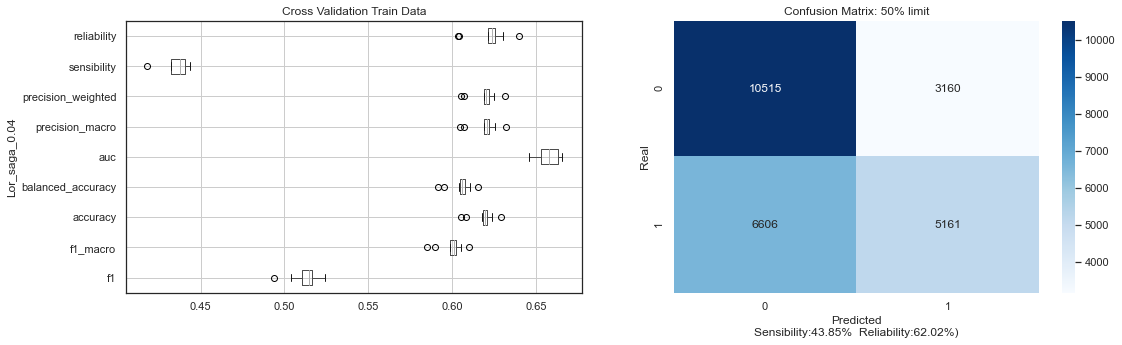

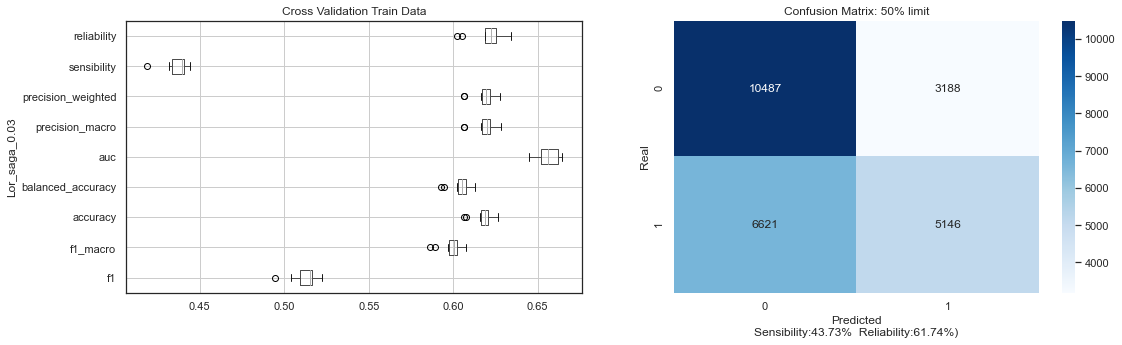

In [170]:
import itertools
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C_list = [0.01, 0.05, 0.1]
model_lor_list = [('Lor_'+str(solver_)+'_'+str(c_), LogisticRegression(random_state=seed,
                                                                       C=c_, 
                                                                       solver=solver_)) for solver_, c_ in itertools.product(solver_list, C_list)]

for name, model in model_lor_list:
    try:
        model_evaluation(model, 
                      X_train_clean, y_train_binomial, 
                      X_test_clean, y_test_binomial, 
                      cv=StratifiedKFold(n_splits=cv_splits),
                      model_name=name
                      )
    except: 
        print(name,' parameters not compatible')

<BarContainer object of 10 artists>

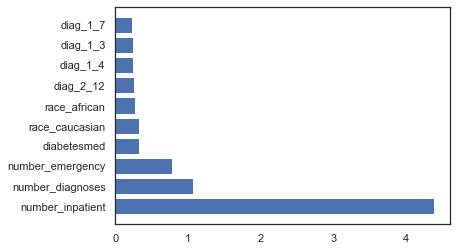

In [200]:
fi_df = pd.DataFrame(list(zip(X_train_clean.columns,model_lor_list[-1][1].coef_[0])), columns=['colname', 'feat_imp'])
fi_df = fi_df.sort_values('feat_imp', ascending=False)[:10]
plt.barh(fi_df['colname'], fi_df['feat_imp'])

#### Desición Tree

In [172]:
criterion_list = ['gini', 'entropy']
max_depth_list = [3, 6, 9]
max_features_list = ['log2', 'sqrt', None]
list(itertools.product(criterion_list, max_depth_list, max_features_list))

[('gini', 3, 'log2'),
 ('gini', 3, 'sqrt'),
 ('gini', 3, None),
 ('gini', 6, 'log2'),
 ('gini', 6, 'sqrt'),
 ('gini', 6, None),
 ('gini', 9, 'log2'),
 ('gini', 9, 'sqrt'),
 ('gini', 9, None),
 ('entropy', 3, 'log2'),
 ('entropy', 3, 'sqrt'),
 ('entropy', 3, None),
 ('entropy', 6, 'log2'),
 ('entropy', 6, 'sqrt'),
 ('entropy', 6, None),
 ('entropy', 9, 'log2'),
 ('entropy', 9, 'sqrt'),
 ('entropy', 9, None)]

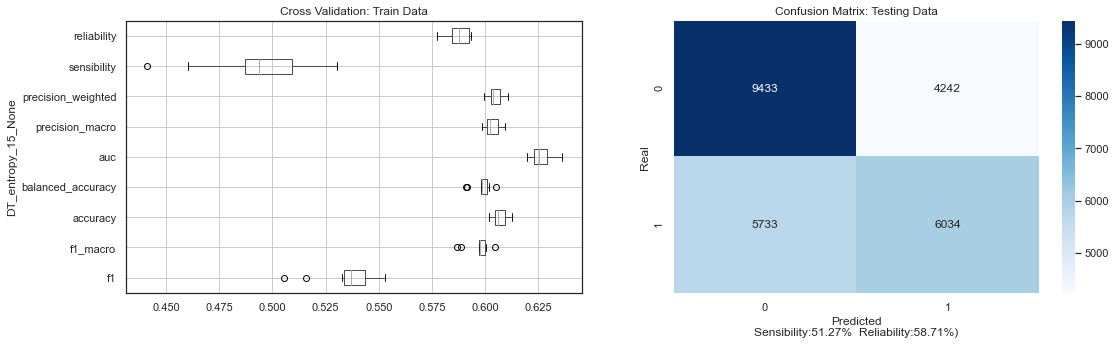

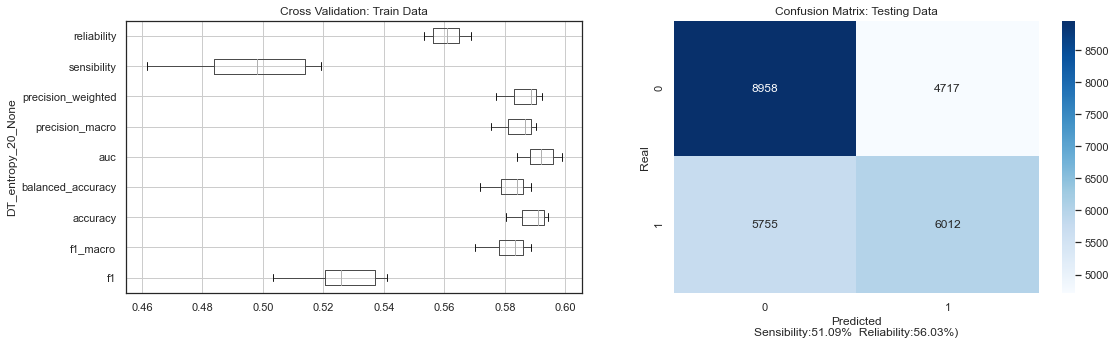

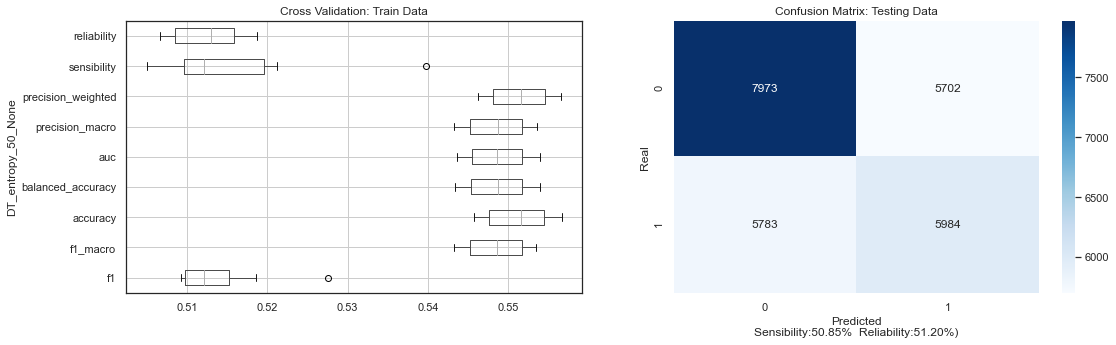

In [179]:
import itertools
criterion_list = ['gini', 'entropy']
max_depth_list = [3, 6, 9, 12, 15, 20, 50]
max_features_list = ['log2', 'sqrt', None]
model_dt_list = [('DT_'+str(criterion_)+'_'+str(max_depth_)+'_'+str(max_features_), DecisionTreeClassifier(random_state=seed, 
                                                        criterion=criterion_, max_depth=max_depth_, max_features=max_features_)
                                        ) for criterion_, max_depth_, max_features_ in itertools.product(criterion_list, max_depth_list, max_features_list)]

for name, model in model_dt_list:
    try:
        model_evaluation(model, 
                      X_train_clean, y_train_binomial, 
                      X_test_clean, y_test_binomial, 
                      cv=StratifiedKFold(n_splits=cv_splits),
                      model_name=name
                      )
    except: 
        print(name,' parameters not compatible')

<BarContainer object of 10 artists>

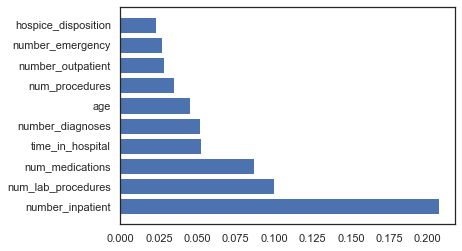

In [198]:
fi_df = pd.DataFrame(list(zip(X_train_clean.columns,model_dt_list[0][1].feature_importances_)), columns=['colname', 'feat_imp'])
fi_df = fi_df.sort_values('feat_imp', ascending=False)[:10]
plt.barh(fi_df['colname'], fi_df['feat_imp'])

#### Random Forest

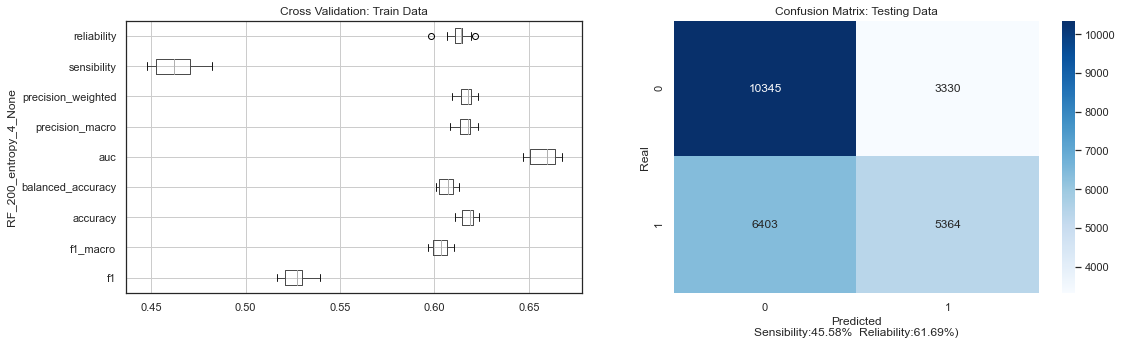

In [201]:
import itertools
n_estimators_list = [200]#50, 100, 
criterion_list = ['entropy']#'gini', 
max_depth_list = [4]#, 8, 12, 16]
max_features_list = [None]#'log2', 'sqrt', 
iter_combination =  itertools.product(n_estimators_list, criterion_list, max_depth_list, max_features_list)
model_rf_list = [('RF_'+str(ne_)+'_'+str(c_)+'_'+str(md_)+'_'+str(mf_), RandomForestClassifier(random_state=seed, 
                                                    n_estimators=ne_, criterion=c_, max_depth=md_, max_features=mf_)
                                        ) for ne_, c_, md_, mf_ in iter_combination]

for name, model in model_rf_list:
    try:
        model_evaluation(model, 
                      X_train_clean, y_train_binomial, 
                      X_test_clean, y_test_binomial, 
                      cv=StratifiedKFold(n_splits=cv_splits),
                      model_name=name
                      )
    except: 
        print(name,' parameters not compatible')

<BarContainer object of 10 artists>

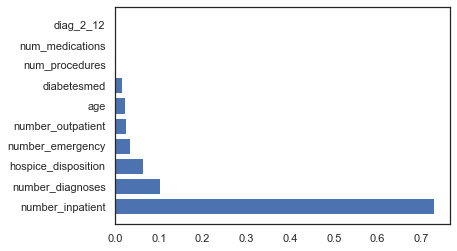

In [216]:
fi_df = pd.DataFrame(list(zip(X_train_clean.columns,model_rf_list[0][1].feature_importances_)), columns=['colname', 'feat_imp'])
fi_df = fi_df.sort_values('feat_imp', ascending=False)[:10]
plt.barh(fi_df['colname'], fi_df['feat_imp'])

In [236]:
!pip install xgboost

/Users/ohuarcaya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:28:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


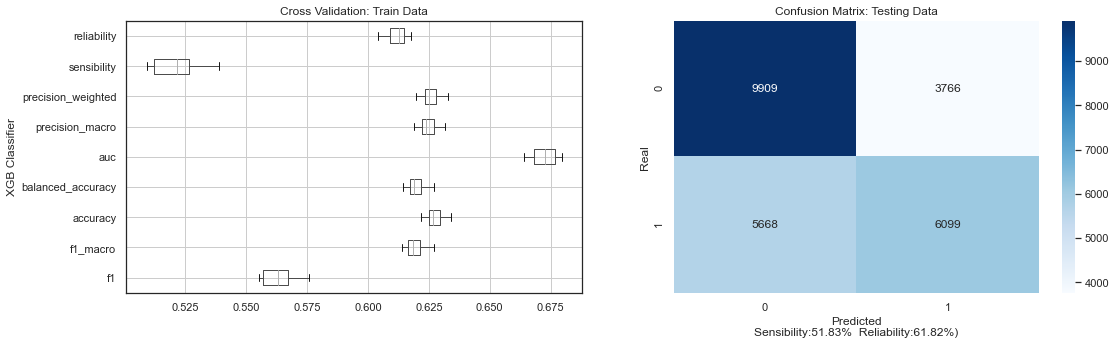

In [237]:
from xgboost import XGBClassifier
from matplotlib import pyplot
"""
mif = ["number_inpatient", "num_medications", "num_lab_procedures", "time_in_hospital", "num_procedures",
                 "number_diagnoses", "number_emergency","diabetesmed","diag_2_12", "age", "diag_1_7","diag_1_3","diag_1_4",
                             "race_caucasian","race_african"]
X_train_xgb = X_train_clean[mif]
X_test_xgb = X_test_clean[mif]
"""

model = XGBClassifier()
model_evaluation(model, X_train_clean, y_train_binomial, X_test_clean, y_test_binomial, 
                 cv=StratifiedKFold(n_splits=cv_splits), 
                 model_name='XGB Classifier')

<BarContainer object of 10 artists>

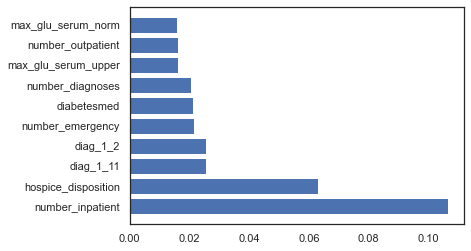

In [238]:
fi_df = pd.DataFrame(list(zip(X_train_clean.columns,model.feature_importances_)), columns=['colname', 'feat_imp'])
fi_df = fi_df.sort_values('feat_imp', ascending=False)[:10]
plt.barh(fi_df['colname'], fi_df['feat_imp'])

In [ ]:
model_dt_list[0][1]
model_rf_list[0][1]
model_lor_list[-1][1]
model

In [ ]:
"""from sklearn.metrics import recall_score
scoring_ = {
            'f1': 'f1',
            'f1_macro': 'f1_macro',
            'accuracy': 'accuracy',
            'balanced_accuracy': 'balanced_accuracy',
            'auc': 'roc_auc',
            'precision_macro': make_scorer(precision_macro),
            'precision_weighted': make_scorer(precision_weighted),
            'sensibility': 'recall',
            'reliability': make_scorer(reliability_score)
          }"""



# EXTRA



### hacer un clustering de aquellos pacientes que por lo menos han sido readmitidos una vez 

In [156]:
X_train_k, ohenc = clean(X_train)
#X_train_k = apply_scale(X_train_clean, {'std': std_scaler, 'mm': min_max_scaler})

In [157]:
from sklearn import cluster
K = 2  
clf = cluster.KMeans(init='random', n_clusters=K, random_state=0)
clf.fit(X_train_clean)  # Train the clustering modeL
clusters = clf.predict(X_train_k)
centroids = clf.cluster_centers_
print(clf, clusters, centroids, sep='\n\n')

KMeans(init='random', n_clusters=2, random_state=0)

[1 1 1 ... 1 1 1]

[[ 6.61011147e-01  1.17606168e+00  3.13799392e-01 -4.74566970e-01
   2.54812907e+00  1.93336972e-02  3.35524109e-03  3.55823588e-02
   4.22055552e-01  2.04878552e-01  4.89231404e-02  1.22445469e-01
   1.01906007e-01  6.92389734e-02  6.01561962e-02  5.25528108e-01
   4.55618248e-01  7.65309984e-01  7.39334618e-01  1.95245304e-01
   2.15887979e-02  4.47688020e-01  4.92155783e-02  1.16132251e-01
   2.96566435e-02  3.10844285e-02  8.63551916e-03  2.40229134e-01
   2.07992156e-01  5.59416500e-02  6.74327393e-03  2.96222390e-02
   4.85446914e-02  3.44044588e-04  8.54262712e-02  6.54028762e-02
   1.80279364e-02  2.75923760e-02  1.29687608e-01  1.12158536e-02
   2.76955893e-02  1.42090415e-02  2.35085667e-01  1.20432808e-01
   9.29436455e-02  2.92437900e-04  8.32415881e-02  3.76040735e-02
   1.64281291e-02  9.63324847e-04  4.92155783e-02  2.67322645e-02
   1.89568568e-02  2.46335925e-02  2.33399849e-01  2.68526801e-02
   3

Text(0.5, 1.0, 'Clusters 1')

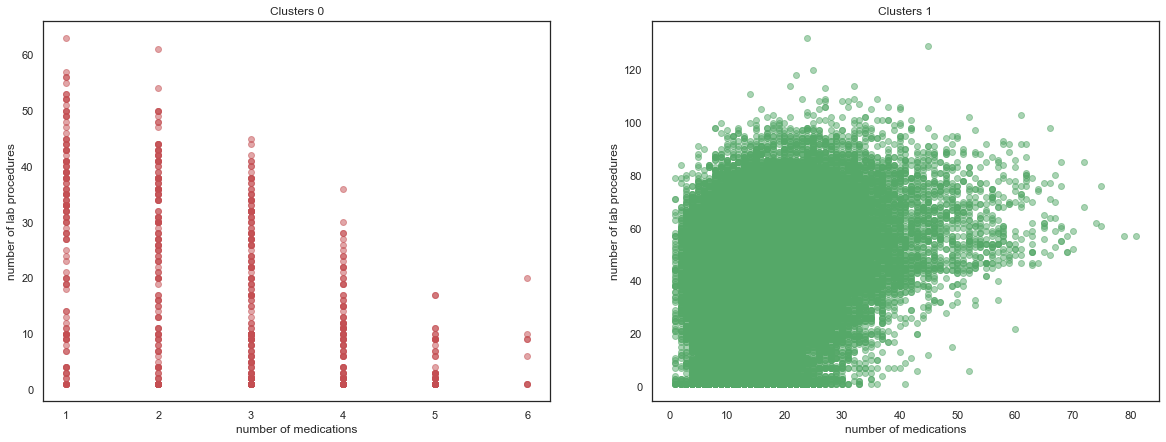

In [212]:
fig, ax = plt.subplots(1,2, figsize=(20,7)) 
sns.set(style="white")
ax[0].scatter(x=list(X_train_k[(clusters==0)]["num_medications"]),
            y=list(X_train_k[(clusters==0)]["num_lab_procedures"]),
            color="r", alpha = 0.5)
ax[1].scatter(x=list(X_train_k[(clusters==1)]["num_medications"]),
            y=list(X_train_k[(clusters==1)]["num_lab_procedures"]),
            color="g", alpha = 0.5)
ax[0].set_xlabel('number of medications')
ax[0].set_ylabel('number of lab procedures')
ax[1].set_xlabel('number of medications')
ax[1].set_ylabel('number of lab procedures')
ax[0].set_title('Clusters 0')
ax[1].set_title('Clusters 1')

Text(0.5, 1.0, 'Cluster 2')

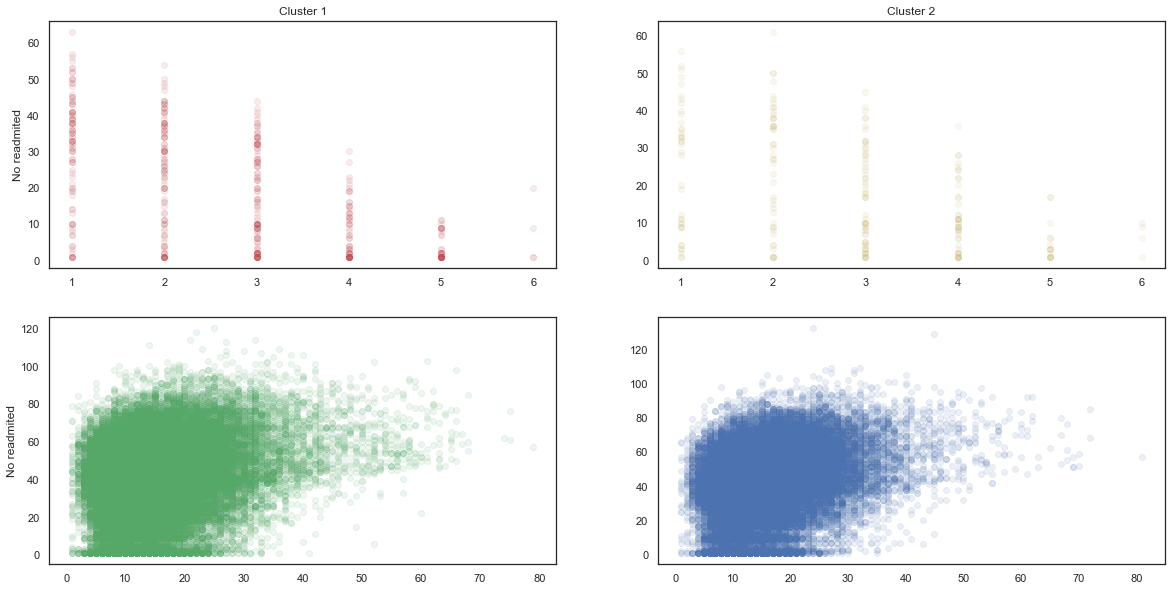

In [215]:
fig, ax = plt.subplots(2,2, figsize=(20,10)) 
sns.set(style="white")
ax[0][0].scatter(x=list(X_train_k[(clusters==0) & (y_train=="NO")]["num_medications"]),
            y=list(X_train_k[(clusters==0) & (y_train=="NO")]["num_lab_procedures"]),
            color="r", alpha = 0.1) #CLUSTER 1 NO READMITIDOS
ax[0][1].scatter(x=list(X_train_k[(clusters==0) & (y_train!="NO")]["num_medications"]),
            y=list(X_train_k[(clusters==0) & (y_train!="NO")]["num_lab_procedures"]),
            color="y", alpha = 0.1) #CLUSTER 1 SI READMITIDOS
ax[1][0].scatter(x=list(X_train_k[(clusters==1) & (y_train=="NO")]["num_medications"]),
            y=list(X_train_k[(clusters==1) & (y_train=="NO")]["num_lab_procedures"]),
            color="g", alpha = 0.1) #CLUSTER 2 NO READMITIDOS
ax[1][1].scatter(x=list(X_train_k[(clusters==1) & (y_train!="NO")]["num_medications"]),
            y=list(X_train_k[(clusters==1) & (y_train!="NO")]["num_lab_procedures"]),
            color="b", alpha = 0.1) #CLUSTER 2 SI READMITIDOS
ax[0][0].set_ylabel("No readmited")
ax[1][0].set_ylabel("No readmited")
ax[0][0].set_title("Cluster 1")
ax[0][1].set_title("Cluster 2")